In [1]:
%load_ext cython
import cbc, cbc_dp
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pyqtgraph as pg
import pickle
import multiprocessing
import pygmo
from numpy import ma
from scipy import constants
from scipy.ndimage import median_filter, label, labeled_comprehension, binary_fill_holes, binary_closing
from scipy.ndimage import binary_dilation
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cor_path = "exp_results/scan_{0:05}/scan_streaks_{0:05}.h5"
cor_data_path = 'corrected_data/corrected_data'
streaks_mask_path = 'corrected_data/streaks_mask'
bgd_path = 'corrected_data/background'
data_path = 'data/data'
mask_path = 'data/mask'

with h5py.File(cor_path.format(135), 'r') as f135:
    b12_cor_data = f135[cor_data_path][...]
    b12_streaks_mask = f135[streaks_mask_path][...]
    b12_data = f135[data_path][...]
    b12_mask = f135[mask_path][...]
    b12_bgd = f135[bgd_path][...]
frame_shape = b12_mask.shape

In [3]:
pix_size = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
axis = np.array([0., 1., 0.])
f_pos = np.array([120.075, 132.45, 129.1])
pupil = np.array([[1515, 1675], [1557, 1748]])
b12_pos = np.array([119.27333163, 131.87979123, 105.91419768])
lys_pos = np.array([1480 * pix_size, 1155 * pix_size, 150.0])
pupil_size = np.radians([0.65, 1.05])
thetas = np.radians(np.arange(101))

In [128]:
rb_0 = cbc_dp.RecBasis.import_ini('b12_rb_00.ini')
rb_1 = cbc_dp.RecBasis.import_ini('b12_rb_01.ini')
rb_2 = cbc_dp.RecBasis.import_ini('b12_rb_02.ini')

b12_rb_sizes = wavelength / np.array([16.18, 21.23, 24.33]) * 1e7
b12_sset = cbc_dp.ScanSetup.import_ini('b12_geom_00.ini')

In [129]:
with h5py.File(cor_path.format(135), 'r') as f135:
    b12_scan = cbc_dp.ScanStreaks(raw_lines=f135['streaks/lines'][...],
                                  exp_set=b12_sset,
                                  frame_idxs=f135['streaks/frame_idxs'][...])
b12_qs = b12_scan.kout_ref()
basis_f = b12_qs.index()
rb_f = cbc.rec_basis(basis_f)
b12_scan.size

13099

# Data processing pipeline

In [42]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def index_kout_lines(float_t[:, :, ::1] vot_vec, float_t num_ap_x, float_t num_ap_y):
    """
    Return source lines coordinates for a diffraction streaks model

    source - source line origins
    rec_vec - reciprocal vectors
    num_ap_x, num_ap_y - numerical apertires in x- and y-axes
    """
    cdef:
        int a = vot_vec.shape[0], b = vot_vec.shape[1], kk, i, j, k
        uint8_t[:, ::1] mask = np.zeros((a, b), dtype=np.uint8)
        float_t rec_abs, source_phi, source_th, source_x, source_y, source_z
        float_t source_prd, coeff1, coeff2, alpha, betta, gamma, delta, sol_1, sol_2
        float_t[::1] bounds = np.array([num_ap_x, -num_ap_x, num_ap_y, -num_ap_y], dtype=np.float64)
        float_t[:, :, :, ::1] source_lines = np.zeros((a, b, 2, 3), dtype=np.float64)
    for i in range(a):
        for j in range(b):
            rec_abs = sqrt(vot_vec[i, j, 0]**2 + vot_vec[i, j, 1]**2 + vot_vec[i, j, 2]**2)
            source_phi = atan2(vot_vec[i, j, 1], vot_vec[i, j, 0])
            source_th = acos(-vot_vec[i, j, 2] / rec_abs) - acos(rec_abs / 2)
            source_x = -sin(source_th) * cos(source_phi)
            source_y = -sin(source_th) * sin(source_phi)
            source_z =  cos(source_th)
            source_prd = source_x * vot_vec[i, j, 0] + source_y * vot_vec[i, j, 1] + source_z * vot_vec[i, j, 2]
            kk = 0
            for k in range(4):
                coeff1 = source_prd - bounds[k] * vot_vec[i, j, k // 2]
                coeff2 = vot_vec[i, j, (3 - k) // 2]
                alpha = coeff2**2 + vot_vec[i, j, 2]**2
                betta = coeff2 * coeff1
                gamma = coeff1**2 - vot_vec[i, j, 2]**2 * (1 - bounds[k]**2)
                delta = betta**2 - alpha * gamma
                sol_1 = (betta + sqrt(delta)) / alpha
                sol_2 = (betta - sqrt(delta)) / alpha
                if abs(sol_1) < abs(bounds[3 - k]):
                    source_lines[i, j, kk, k // 2] = vot_vec[i, j, k // 2] + bounds[k]
                    source_lines[i, j, kk, (3 - k) // 2] = vot_vec[i, j, (3 - k) // 2] + sol_1
                    source_lines[i, j, kk, 2] = vot_vec[i, j, 2] + sqrt(1 - bounds[k]**2 - sol_1**2)
                    kk += 1
                if delta != 0 and abs(sol_2) < abs(bounds[3 - k]):
                    source_lines[i, j, kk, k // 2] = vot_vec[i, j, k // 2] + bounds[k]
                    source_lines[i, j, kk, (3 - k) // 2] = vot_vec[i, j, (3 - k) // 2] + sol_2
                    source_lines[i, j, kk, 2] = vot_vec[i, j, 2] + sqrt(1 - bounds[k]**2 - sol_2**2)
                    kk += 1
                if kk == 2:
                    mask[i, j] = 1
                    break
    return np.asarray(source_lines), np.asarray(mask).astype(bool)

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def kout_source(float_t[:, :, ::1] kout_exp):
    cdef:
        int a = kout_exp.shape[0], i
        float_t dkout_x, dkout_y, prod, source_x, source_y
        float_t[:, ::1] kout_source = np.empty((a, 3), dtype=np.float64)
    for i in range(a):
        dkout_x = kout_exp[i, 1, 0] - kout_exp[i, 0, 0]
        dkout_y = kout_exp[i, 1, 1] - kout_exp[i, 0, 1]
        prod = kout_exp[i, 1, 0] * dkout_y - kout_exp[i, 1, 1] * dkout_x
        kout_source[i, 0] = dkout_y * prod / (dkout_x**2 + dkout_y**2)
        kout_source[i, 1] = -dkout_x * prod / (dkout_x**2 + dkout_y**2)
        kout_source[i, 2] = sqrt(1 - kout_source[i, 0]**2 - kout_source[i, 1]**2)
    return np.asarray(kout_source)

In [76]:
f135_2 = h5py.File("exp_results/scan_{0:05}/scan_corrected_{0:05}.h5".format(135), 'r')
b12_bgd2 = f135_2['corrected_data/background'][:]
b12_cor_data2 = f135_2['corrected_data/corrected_data'][:]
with h5py.File("exp_results/scan_{0:05}/scan_raw_{0:05}.h5".format(134), 'r') as file:
    exp_bgd = file['data/data'][0]
bad_mask = np.load('cbc_dp/utils/b12_mask.npy')
f135_2.close()

In [217]:
bad_mask = np.load('cbc_dp/utils/b12_mask.npy')
with h5py.File("exp_results/scan_{0:05}/scan_raw_{0:05}.h5".format(134), 'r') as file:
    exp_bgd = file['data/data'][0]
scan = cbc_dp.open_scan('b12_2', 135)

In [218]:
cor_data = cbc_dp.CorrectedData(b12_data, exp_bgd, bad_mask)

In [38]:
cbc_dp.CorrectedData.streak_width = 13
cor_data._mask_data()

In [263]:
norm_data = cbc_dp.NormalizedData(b12_cor_data, b12_streaks_mask)

In [245]:
line_detector = cbc_dp.LineSegmentDetector(scale=0.5, sigma_scale=0.5)
b12_scan = line_detector.det_scan(norm_data.norm_data, b12_exp, 10)
b12_scan.size

13099

In [248]:
out_file = scan._create_outfile(tag='streaks')
scan._save_parameters(out_file)
scan._save_data(out_file)
cor_data.save(out_file)
b12_scan.save(out_file)
out_file.close()

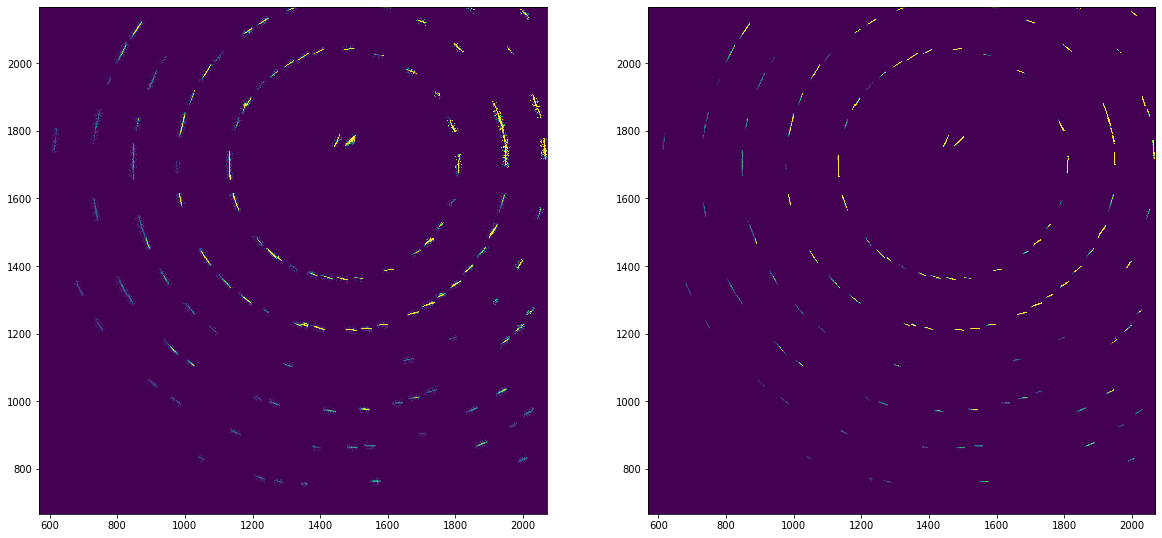

In [37]:
%matplotlib inline
frame_idx = 0
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[frame_idx] * b12_streaks_mask[frame_idx], vmin=0, vmax=50)
axes[1].imshow(b12_cor_data[frame_idx] * streaks_mask(b12_scan[frame_idx].raw_lines,
                                                      structure=cbc_dp.utils.STRUCT,
                                                      width=1, shape_x=frame_shape[0],
                                                      shape_y=frame_shape[1]), vmin=0, vmax=50)
for ax in axes:
    ax.set_xlim(570, 2070)
    ax.set_ylim(667, 2167)
plt.show()
# plt.savefig('figures/norm_frame.pdf')

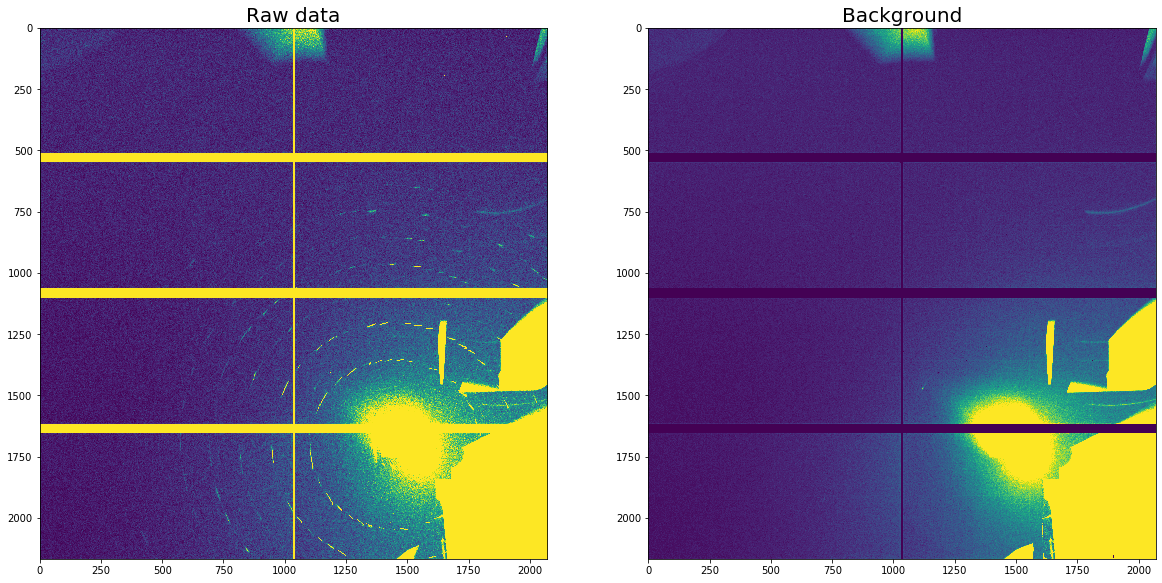

In [84]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_data[frame_idx], vmin=0, vmax=50)
axes[0].set_title('Raw data', fontsize=20)
axes[1].imshow(b12_bgd[frame_idx], vmin=0, vmax=50)
axes[1].set_title('Background', fontsize=20)
plt.show()
# plt.savefig('figures/dp_pipeline1.pdf')

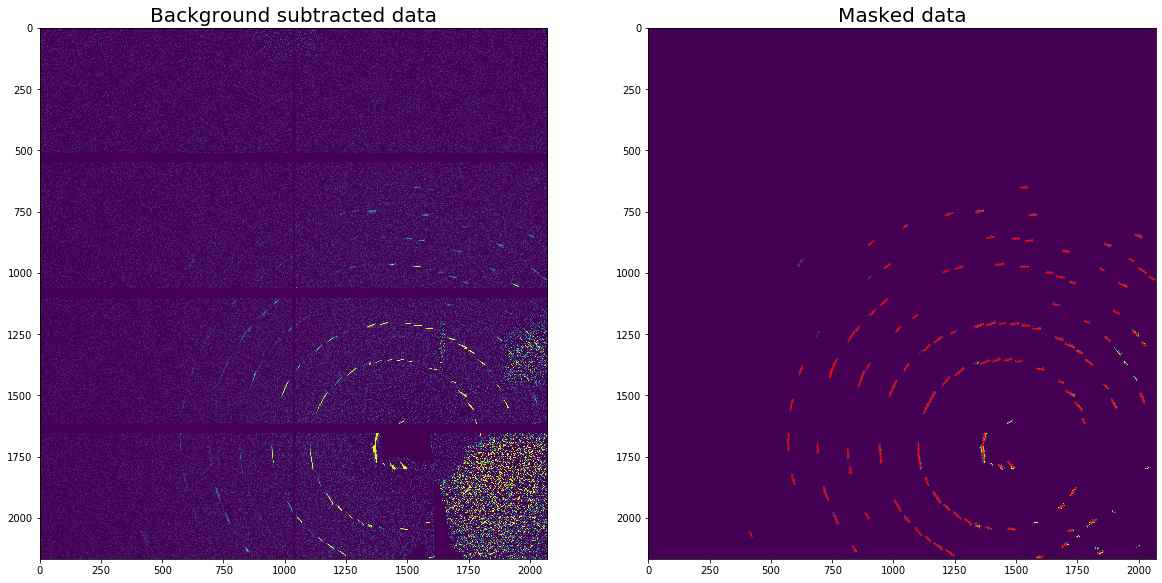

In [82]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[frame_idx], vmin=0, vmax=50)
axes[0].set_title('Background subtracted data', fontsize=20)
axes[1].imshow(b12_cor_data[frame_idx] * b12_streaks_mask[frame_idx], vmin=0, vmax=50)
axes[1].set_title('Masked data', fontsize=20)
for line in b12_scan[frame_idx].raw_lines:
    axes[1].plot(line[:, 0], line[:, 1], 'r')
plt.show()
# plt.savefig('figures/dp_pipeline2.pdf')

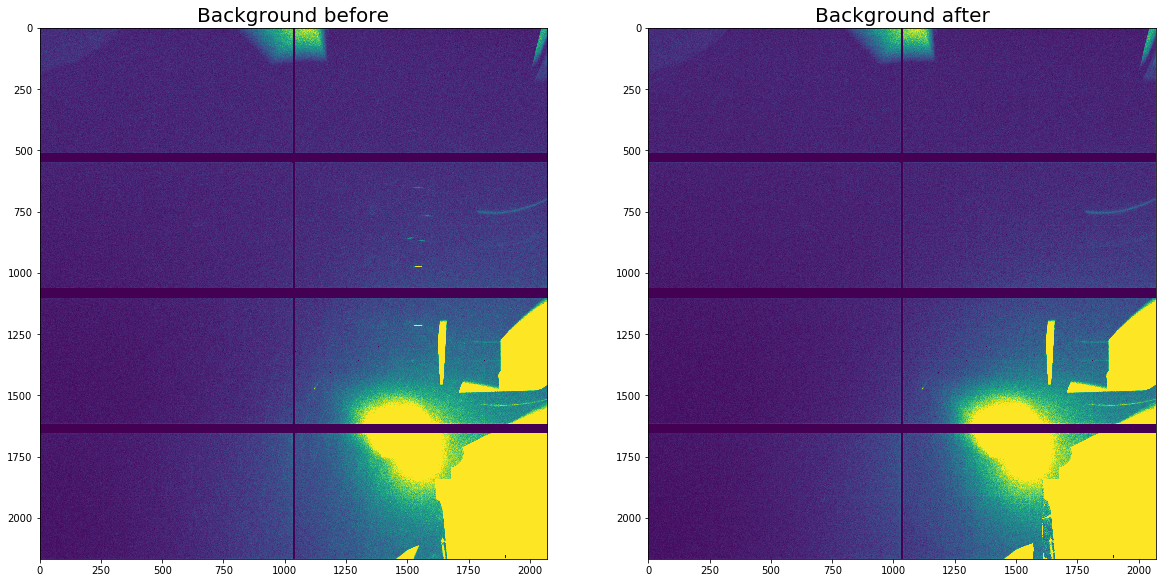

In [77]:
%matplotlib inline
frame_idx = 1
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_bgd2[frame_idx], vmin=0, vmax=50)
axes[1].imshow(b12_bgd[frame_idx], vmin=0, vmax=50)
axes[0].set_title('Background before', fontsize=20)
axes[1].set_title('Background after', fontsize=20)
plt.show()
# plt.savefig('figures/background.pdf')

# Experimental geometry

In [280]:
frame_idx = 80
pupil = np.array([[1515, 1675], [1558, 1750]])
imax = b12_bgd[frame_idx, pupil[0, 1]:pupil[1, 1], pupil[0, 0]:pupil[1, 0]].max()
ii, jj = np.where(b12_bgd[frame_idx, pupil[0, 1]:pupil[1, 1], pupil[0, 0]:pupil[1, 0]] > imax / 10)
ii.min(), ii.max(), jj.min(), jj.max()

(24, 73, 3, 41)

In [11]:
pupil_list = []
for bgd in b12_bgd:
    imax = bgd[pupil[0, 1]:pupil[1, 1], pupil[0, 0]:pupil[1, 0]].max()
    ii, jj = np.where(bgd[pupil[0, 1]:pupil[1, 1], pupil[0, 0]:pupil[1, 0]] > imax / 5)
    frame_pupil = np.array([[jj.min(), ii.min()], [jj.max(), ii.max()]])
    pupil_list.append(frame_pupil)
scan_pupil = (np.stack(pupil_list) + pupil[0])

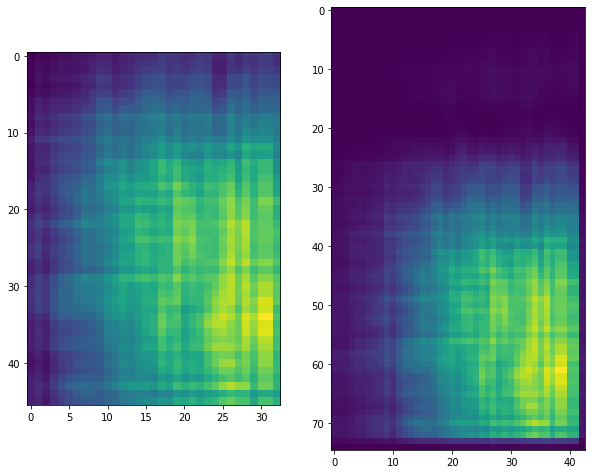

In [299]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(b12_bgd[frame_idx, scan_pupil[frame_idx, 0, 1]:scan_pupil[frame_idx, 1, 1],
                       scan_pupil[frame_idx, 0, 0]:scan_pupil[frame_idx, 1, 0]])
axes[1].imshow(b12_bgd[frame_idx, pupil[0, 1]:pupil[1, 1], pupil[0, 0]:pupil[1, 0]])
plt.show()

# Pattern refinement

In [51]:
frame_idx = 70
rb = rb_2
eul_ang = b12_sset.euler_angles(frame_idx)
start_point = np.concatenate((f_pos, b12_pos, rb.sizes, eul_ang))
rot_tf = cbc_dp.RCBI(streaks=b12_scan[frame_idx], frame_idx=frame_idx, rec_basis=rb,
                     f_tol=(1e-3, 1e-3, 1e-3), smp_tol=(0.05, 0.05, 0.05),
                     rb_tol=1e-3, ang_tol=0.1, pen_coeff=1.)

algo = pygmo.algorithm(pygmo.de(3000))
prob = pygmo.problem(rot_tf)
pop = pygmo.population(prob, size=50)
pop = algo.evolve(pop)
rot_ch = pop.champion_x

print(rot_tf.fitness(start_point)[0], rot_tf.fitness(rot_ch)[0], sep='\t')
print((rot_ch[:3] - f_pos) / f_pos)
print((rot_ch[3:6] - b12_pos) / b12_pos)
print((rot_ch[9:] - eul_ang))

0.010713690458155333	0.005969815126119983
[ 7.45123683e-05  9.99717954e-04 -9.87709435e-04]
[-0.00133327  0.00047937 -0.00205068]
[-0.00494736 -0.0086433  -0.00168791]


In [33]:
frame_idx = 70
rb = rb_new
eul_ang = b12_sset.euler_angles(frame_idx)
start_point = np.concatenate((f_pos_new, b12_pos, rb.sizes, eul_ang))
rot_tf = cbc_dp.RCBI(streaks=b12_scan_new[frame_idx], frame_idx=frame_idx, rec_basis=rb,
                     f_tol=(1e-3, 1e-3, 1e-3), smp_tol=(0.05, 0.05, 0.05),
                     rb_tol=1e-3, ang_tol=0.1, pen_coeff=1.)

algo = pygmo.algorithm(pygmo.de(3000))
prob = pygmo.problem(rot_tf)
pop = pygmo.population(prob, size=50)
pop = algo.evolve(pop)
rot_ch = pop.champion_x

print(rot_tf.fitness(start_point)[0], rot_tf.fitness(rot_ch)[0], sep='\t')
print((rot_ch[:3] - f_pos) / f_pos)
print((rot_ch[3:6] - b12_pos) / b12_pos)
print((rot_ch[9:] - eul_ang))

0.00812392925242218	0.0056002628322825015
[-0.00228451 -0.00015292 -0.00100298]
[-0.00334912 -0.00113787 -0.00999042]
[ 0.00349437 -0.00432032 -0.00336464]


In [34]:
model = cbc_dp.RectModel(rec_lat=cbc_dp.BallLattice(rot_tf.rec_basis(rot_ch), 0.75),
                         kin=rot_tf.kin_bounds(rot_ch))
m_kout = model.kout()
m_kout_lines = model.kout_lines()
model_lines = rot_tf.det_kout(m_kout_lines[..., 0], m_kout_lines[..., 1], rot_ch)
model_pts = rot_tf.det_kout(m_kout[..., 0], m_kout[..., 1], rot_ch)

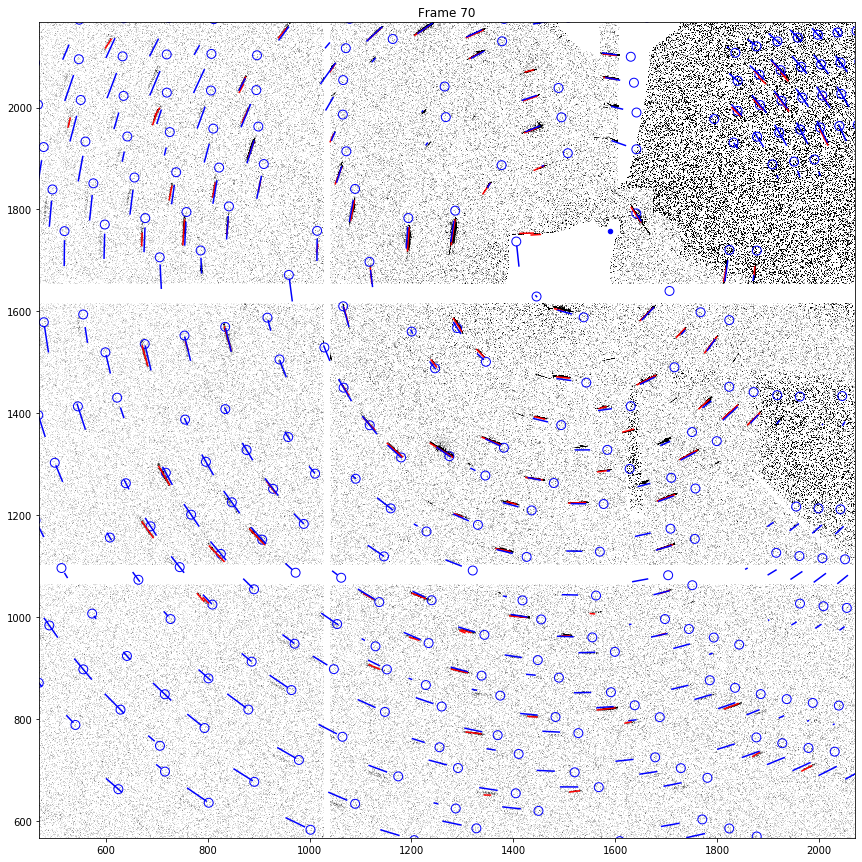

In [35]:
%matplotlib inline
exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx],
          vmin=0, vmax=20, cmap='gray_r')
for line in b12_scan[frame_idx].raw_lines:
    ax.plot(line[..., 0], line[..., 1], 'r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
for line in model_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
ax.scatter(b12_sset.smp_pos[0] / pix_size, b12_sset.smp_pos[1] / pix_size, 20, 'b')
ax.set_xlim(470, 2070)
ax.set_ylim(567, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()
# plt.savefig('figures/rot_model_10.pdf')

In [36]:
hkl_idxs = rot_tf.hkl_idxs(rot_ch)
model = cbc_dp.RectModel(rec_lat=cbc_dp.RecLattice(rot_tf.rec_basis(rot_ch), hkl_idxs),
                         kin=rot_tf.kin_bounds(rot_ch))
m_kout = model.kout()
m_kout_lines = model.kout_lines()
model_lines = rot_tf.det_kout(m_kout_lines[..., 0], m_kout_lines[..., 1], rot_ch)
model_pts = rot_tf.det_kout(m_kout[..., 0], m_kout[..., 1], rot_ch)
kins = rot_tf.kout_exp(rot_ch) - rot_tf.rec_vectors(rot_ch)[:, None]

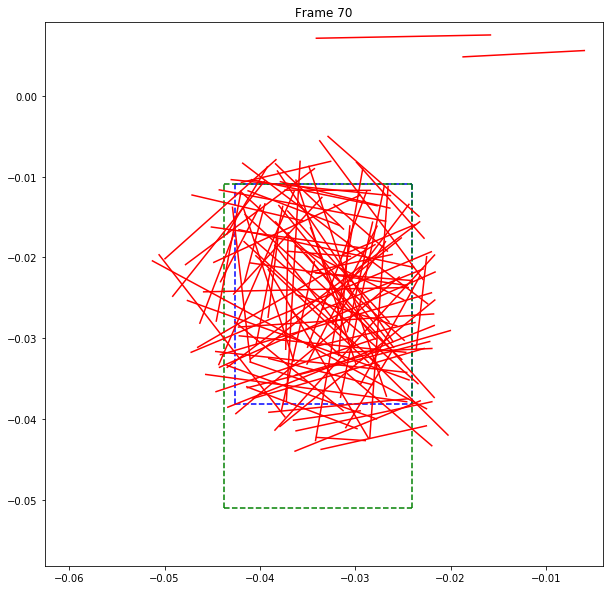

In [37]:
%matplotlib inline
kin = (b12_sset.pupil_bounds(0) - rot_ch[:2]) / rot_ch[2]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(np.linspace(model.kin[0, 0], model.kin[1, 0]), model.kin[0, 1] * np.ones(50), 'b--')
ax.plot(np.linspace(model.kin[0, 0], model.kin[1, 0]), model.kin[1, 1] * np.ones(50), 'b--')
ax.plot(model.kin[0, 0] * np.ones(50), np.linspace(model.kin[0, 1], model.kin[1, 1]), 'b--')
ax.plot(model.kin[1, 0] * np.ones(50), np.linspace(model.kin[0, 1], model.kin[1, 1]), 'b--')
ax.plot(np.linspace(kin[0, 0], kin[1, 0]), kin[0, 1] * np.ones(50), 'g--')
ax.plot(np.linspace(kin[0, 0], kin[1, 0]), kin[1, 1] * np.ones(50), 'g--')
ax.plot(kin[0, 0] * np.ones(50), np.linspace(kin[0, 1], kin[1, 1]), 'g--')
ax.plot(kin[1, 0] * np.ones(50), np.linspace(kin[0, 1], kin[1, 1]), 'g--')
for line in kins:
    ax.plot(line[:, 0], line[:, 1], 'r')
offset = 0.02
ax.set_xlim(model.kin[0, 0] - offset, model.kin[1, 0] + offset)
ax.set_ylim(model.kin[0, 1] - offset, model.kin[1, 1] + offset)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()
# plt.savefig('figures/full_pupil_10.pdf')

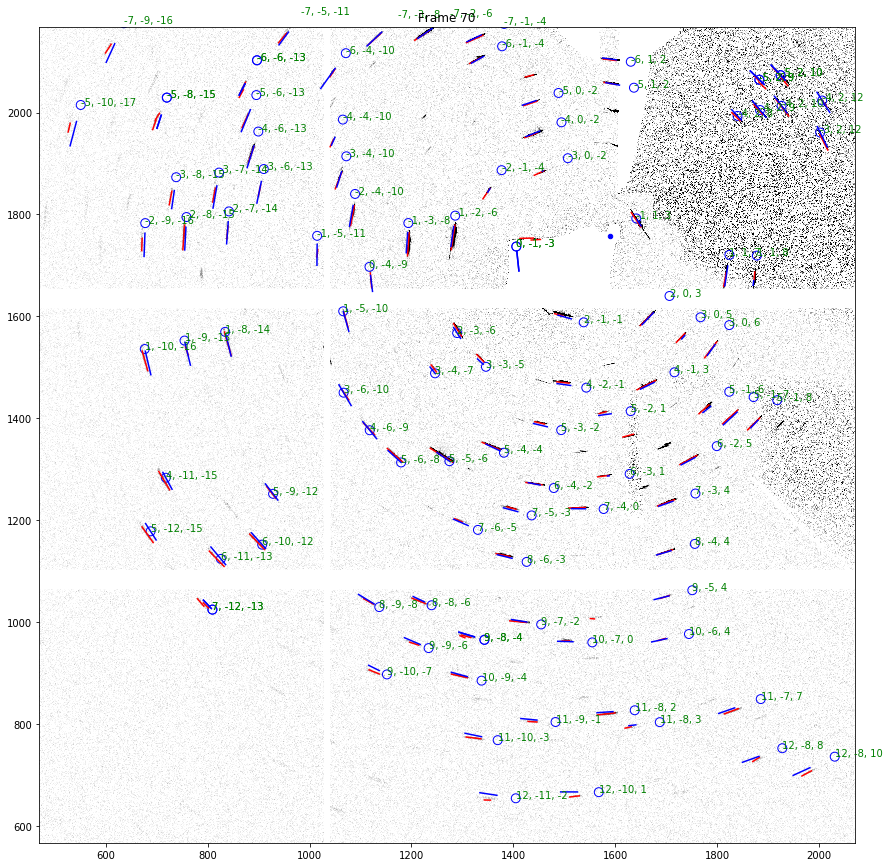

In [38]:
%matplotlib inline
exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50, cmap='gray_r')
for line in b12_scan[frame_idx].raw_lines:
    ax.plot(line[..., 0], line[..., 1], 'r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
for line in model_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
ax.scatter(b12_sset.smp_pos[0] / pix_size, b12_sset.smp_pos[1] / pix_size, 20, 'b')
for pt, hkl in zip(model_pts, model.hkl_idxs):
    ax.text(pt[0], pt[1], '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl.astype(np.int)), color='g', fontsize=10)
ax.set_xlim(470, 2070)
ax.set_ylim(567, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()
# plt.savefig('figures/full_index_10.pdf')

In [6]:
scan, rb = b12_scan[20::20], rb_2
start_point = np.concatenate((rb.rb_mat.ravel(),
                              np.tile(b12_sset.smp_pos, scan.frames.size),
                              b12_sset.eul_ang[scan.frames].ravel()))
scan_tf = cbc_dp.ScanCBI(streaks=scan, rec_basis=rb, f_tol=(1e-2, 1e-2, 1e-3),
                         smp_tol=(5e-2, 5e-2, 5e-2), rb_tol=3e-3, ang_tol=0.1)
prob = pygmo.problem(scan_tf)
algo = pygmo.algorithm(pygmo.moead(gen=300, weight_generation='grid'))
algo.set_verbosity(25)

ps = cbc_dp.utils.scan_ps(2000, scan.frames.size)
pops = [pygmo.population(prob, size=ps, b=pygmo.mp_bfe()) for _ in range(12)]
archi = pygmo.archipelago()
for pop in pops:
    archi.push_back(algo=algo, pop=pop)
print(ps)

1820


In [7]:
archi.evolve()

In [11]:
print(archi)

Number of islands: 12
Topology: Unconnected
Migration type: point-to-point
Migrant handling policy: preserve
Status: busy

Islands summaries:

	#   Type                    Algo                Prob                                Size  Status  
	--------------------------------------------------------------------------------------------------
	0   Multiprocessing island  MOEAD: MOEA/D - DE  A convergent beam indexing problem  1820  busy    
	1   Multiprocessing island  MOEAD: MOEA/D - DE  A convergent beam indexing problem  1820  busy    
	2   Multiprocessing island  MOEAD: MOEA/D - DE  A convergent beam indexing problem  1820  busy    
	3   Multiprocessing island  MOEAD: MOEA/D - DE  A convergent beam indexing problem  1820  busy    
	4   Multiprocessing island  MOEAD: MOEA/D - DE  A convergent beam indexing problem  1820  busy    
	5   Multiprocessing island  MOEAD: MOEA/D - DE  A convergent beam indexing problem  1820  busy    
	6   Multiprocessing island  MOEAD: MOEA/D - DE  A conver

In [36]:
# archi.wait()
ev_pops = [island.get_population() for island in archi]
index_sol = np.concatenate([pop.get_x() for pop in ev_pops])
index_pts = np.concatenate([pop.get_f() for pop in ev_pops])

In [37]:
rb = rb_2
archi = scan.rot_index(rec_basis=rb, n_isl=1, pop_size=50, gen_num=3000, f_tol=(1e-3, 1e-3, 1e-4),
                       smp_tol=(5e-2, 5e-2, 5e-2), rb_tol=1e-3, ang_tol=0.1)
archi.evolve()
archi.wait()
det_pos = np.concatenate([sol[3:6] for sol in archi.get_champions_x()])
eul_ang = np.concatenate([sol[9:] for sol in archi.get_champions_x()])
point = np.concatenate([f_pos, rb.rb_mat.ravel(), det_pos, eul_ang])

In [24]:
best_idx = np.argmin(index_pts.mean(axis=-1))
index_pts[best_idx], scan_tf.fitness(point)

NameError: name 'index_pts' is not defined

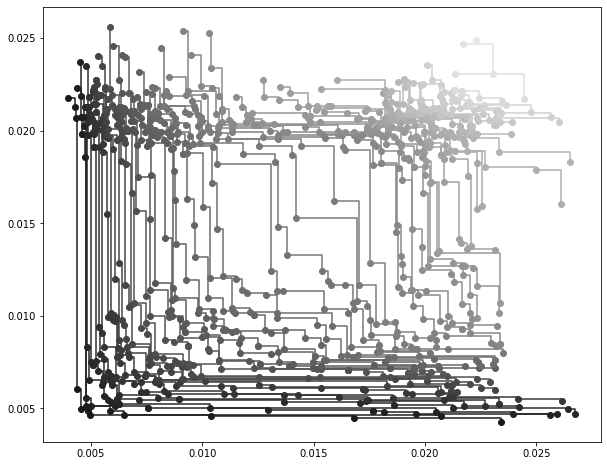

In [42]:
%matplotlib inline
plt.figure(figsize=(10, 8))
pygmo.plot_non_dominated_fronts(index_pts[:1000, 4:6])
plt.show()

# Indexing results

In [202]:
with h5py.File('exp_results/scan_00135/index/135_rot_index_04.h5', 'r') as ri_file:
    ri_sol = ri_file['data/index_sol'][...]
    ri_pts = ri_file['data/index_pts'][...]
    rb = cbc_dp.RecBasis(ri_file['config/rb_mat'][...])
    f_tol = ri_file['config/f_tol'][...]
    smp_tol = ri_file['config/smp_tol'][...]
    rb_tol = ri_file['config/rb_tol'][...]
    ang_tol = ri_file['config/ang_tol'][...]
print(rb.rb_mat, smp_tol, f_tol, rb_tol)
idxs = (np.argmin(ri_pts, axis=0), np.arange(ri_sol.shape[1]))
ri_sol = ri_sol[idxs]

[[ 0.00822553 -0.04392742 -0.00112285]
 [ 0.03024139  0.00603186  0.00214177]
 [ 0.00255398  0.00087035 -0.02748237]] [0.05 0.05 0.08] [0.001  0.001  0.0001] 0.01


In [131]:
b12_sset = cbc_dp.ScanSetup.import_ini('b12_geom_02.ini')
with h5py.File(cor_path.format(135), 'r') as f135:
    b12_scan_new = cbc_dp.ScanStreaks(raw_lines=f135['streaks/lines'][...],
                                      exp_set=b12_sset,
                                      frame_idxs=f135['streaks/frame_idxs'][...])

In [132]:
kin_list, hkl_list = [], []
for frame_idx, (rot_ch, b12_frame) in enumerate(zip(ri_sol, b12_scan_new)):
    rot_tf = cbc_dp.RCBI(streaks=b12_frame, frame_idx=frame_idx, rec_basis=rb,
                         f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    hkl_list.append(rot_tf.hkl_idxs(rot_ch))
    kin_list.append(rot_tf.kout_exp(rot_ch) - rot_tf.rec_vectors(rot_ch)[:, None])
kin_arr = np.concatenate(kin_list)
hkl_arr = np.concatenate(hkl_list)

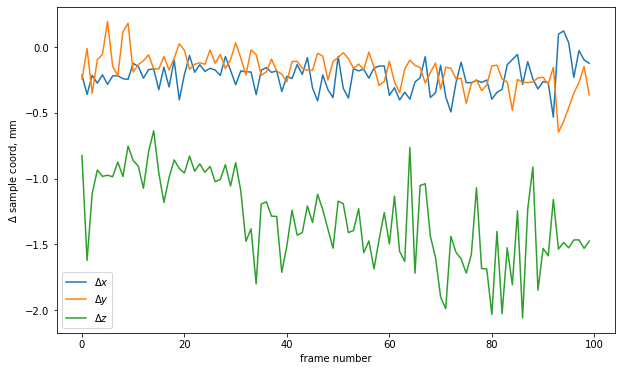

In [176]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(ri_sol[1:, 3] - b12_pos[0], label='$\Delta x$')
ax.plot(ri_sol[1:, 4] - b12_pos[1], label='$\Delta y$')
ax.plot(ri_sol[1:, 5] - b12_pos[2], label='$\Delta z$')
ax.set_xlabel('frame number')
ax.set_ylabel('$\Delta$ sample coord, mm')
ax.legend()
plt.show()
# plt.savefig('figures/rot_index_smp.pdf')

In [134]:
masks = []
for frame_idx, (rot_ch, b12_frame) in enumerate(zip(ri_sol, b12_scan_new)):
    rot_mat = b12_sset.rotation_matrix(frame_idx, inverse=True)
    rot_tf = cbc_dp.RCBI(streaks=b12_frame, frame_idx=frame_idx, rec_basis=rb,
                         f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    kin_arr = rot_tf.kout_exp(rot_ch) - rot_tf.rec_vectors(rot_ch)[:, None]
    det_arr = rot_tf.det_kin(kin_arr[..., 0], kin_arr[..., 1], rot_ch)
    masks.append(cbc_dp.utils.streaks_mask(det_arr, np.ones((1, 1), dtype=np.uint8), 1, frame_shape[0], frame_shape[1]))
masks = np.stack(masks)[..., None] * np.array([1., 0., 0., 0.66])

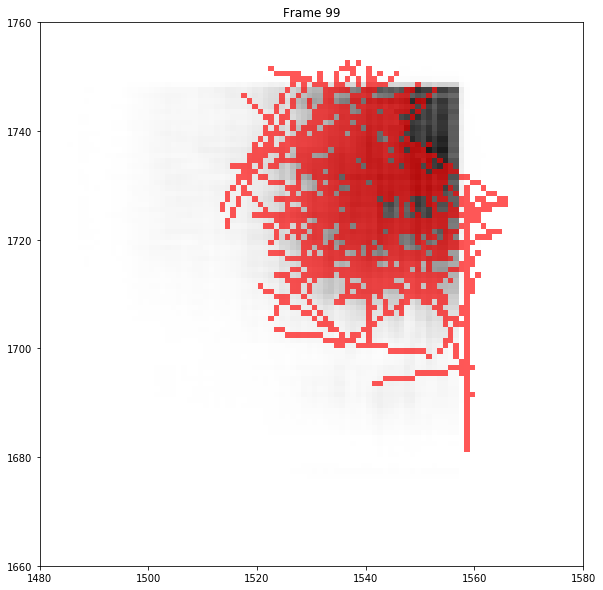

In [151]:
%matplotlib agg

from matplotlib import animation, rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))
im0 = ax.imshow([[]], extent=[0, frame_shape[1], frame_shape[0], 0], cmap='gray_r')
im1 = ax.imshow([[]], extent=[0, frame_shape[1], frame_shape[0], 0])
rc('animation', html='html5')

def init():
    ax.set_xlim(1480, 1580)
    ax.set_ylim(1660, 1760)
    im0.set_clim(400, 4000000)
    im1.set_clim(0, 1)
    return [im0, im1]

def animate1(i):
    ax.set_title("Frame {:d}".format(i))
    im0.set_data(b12_bgd[i])
    im1.set_data(masks[i])
    return [im0, im1]

pupil_mov = animation.FuncAnimation(fig, animate1, init_func=init, interval=100, frames=100, blit=True)
pupil_mov.save('pupil.mp4', extra_args=['-vcodec', 'libx264'])
# HTML(pupil_mov.to_html5_video())

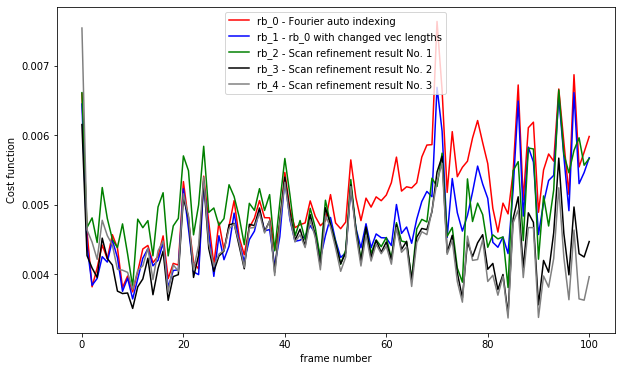

In [178]:
%matplotlib inline
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
with h5py.File('exp_results/scan_00135/index/135_rot_index_00.h5', 'r') as ri_file0:
    ri_pts0 = ri_file0['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_01.h5', 'r') as ri_file1:
    ri_pts1 = ri_file1['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_02.h5', 'r') as ri_file2:
    ri_pts2 = ri_file2['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_03.h5', 'r') as ri_file3:
    ri_pts3 = ri_file3['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_04.h5', 'r') as ri_file4:
    ri_pts4 = ri_file4['data/index_pts'][...]
ax.plot(np.min(ri_pts0, axis=0), 'r', label='rb_0 - Fourier auto indexing')
ax.plot(np.min(ri_pts1, axis=0), 'b', label='rb_1 - rb_0 with changed vec lengths')
ax.plot(np.min(ri_pts2, axis=0), 'g', label='rb_2 - Scan refinement result No. 1')
ax.plot(np.min(ri_pts3, axis=0), 'black', label='rb_3 - Scan refinement result No. 2')
ax.plot(np.min(ri_pts4, axis=0), 'gray', label='rb_4 - Scan refinement result No. 3')
ax.legend()
ax.set_xlabel('frame number')
ax.set_ylabel('Cost function')
plt.show()
# plt.savefig('figures/fit_full.pdf')
print(np.min(ri_pts0, axis=0).sum(), np.min(ri_pts1, axis=0).sum(),
      np.min(ri_pts2, axis=0).sum(), np.min(ri_pts3, axis=0).sum(),
      np.min(ri_pts4, axis=0).sum())

In [7]:
with h5py.File('exp_results/scan_00135/index/b12_index_full.h5', 'r') as fi_file:
    fi_sol = fi_file['data/index_sol'][...]
    fi_pts = fi_file['data/index_pts'][...]
idxs = (np.argmin(fi_pts, axis=0), np.arange(fi_sol.shape[1]))
fi_sol = fi_sol[idxs]

In [6]:
with h5py.File('exp_results/scan_00135/index/135_scan_index_03.h5', 'r') as scan_file:
    scan_sol = scan_file['data/index_sol'][...]
    scan_pts = scan_file['data/index_pts'][...]
    rb = cbc_dp.RecBasis(scan_file['config/rb_mat'][...])
    f_tol = scan_file['config/f_tol'][...]
    smp_tol = scan_file['config/smp_tol'][...]
    rb_tol = scan_file['config/rb_tol'][...]
    ang_tol = scan_file['config/ang_tol'][...]
    print(scan_file['config/gen_num'][...], scan_file['config/pop_size'][...])
best_idx = np.argmin(scan_pts.mean(axis=-1))
scan = b12_scan[10::10]
scan_tf = cbc_dp.ScanCBI(streaks=scan, rec_basis=rb, f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)

500 10000


In [7]:
archi = scan.rot_index(rec_basis=rb, n_isl=1, pop_size=50, gen_num=3000,
                       f_tol=(1e-3, 1e-3, 1e-3), smp_tol=smp_tol, rb_tol=1e-3, ang_tol=ang_tol)
archi.evolve()
archi.wait()
det_pos = np.concatenate([sol[3:6] for sol in archi.get_champions_x()])
eul_ang = np.concatenate([sol[9:] for sol in archi.get_champions_x()])
point = np.concatenate([f_pos, rb.rb_mat.ravel(), det_pos, eul_ang])

In [10]:
best_idx = np.argmin(scan_pts.mean(axis=-1))
scan_pts[best_idx], scan_tf.fitness(point), np.min(ri_pts, axis=0)[10::10]

(array([0.00631736, 0.00594553, 0.00582445, 0.00591047, 0.00512591,
        0.00457199, 0.00598446, 0.00448371, 0.00477481, 0.00493293]),
 array([0.00505572, 0.00706928, 0.00670878, 0.00702596, 0.00619366,
        0.00683802, 0.00958401, 0.0068433 , 0.00601576, 0.00748035]),
 array([0.00350682, 0.0051004 , 0.00473101, 0.00539759, 0.00444183,
        0.00446282, 0.00547052, 0.00407066, 0.00355988, 0.00446987]))

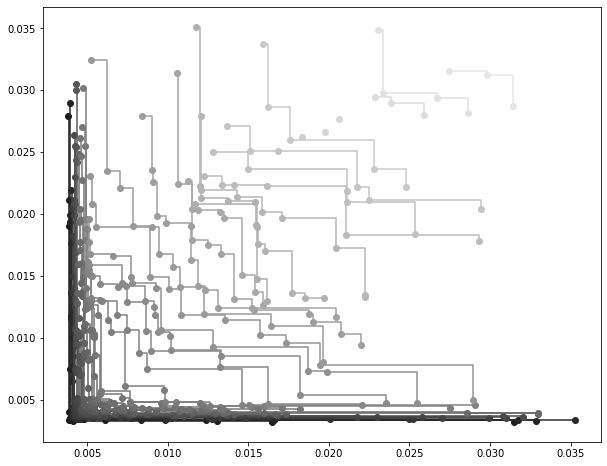

In [11]:
%matplotlib inline
idxs = np.random.choice(scan_pts.shape[0], 500)
plt.figure(figsize=(10, 8))
pygmo.plot_non_dominated_fronts(scan_pts[idxs, 7:9])
plt.show()

In [12]:
f_pos_new = scan_sol[best_idx, :3]
rb_new = cbc_dp.RecBasis(scan_sol[best_idx, 3:12].reshape((3, 3)))
b12_sset_new = cbc_dp.ScanSetup(pix_size=pix_size, smp_pos=b12_pos, f_pos=f_pos_new, pupil=b12_sset.pupil,
                                axis=axis, thetas=thetas)
with h5py.File(cor_path.format(135), 'r') as f135:
    b12_scan_new = cbc_dp.ScanStreaks(raw_lines=f135['streaks/lines'][...],
                                  exp_set=b12_sset_new,
                                  frame_idxs=f135['streaks/frame_idxs'][...])

In [41]:
b12_sset_new.save_ini('b12_geom_02.ini')
rb_new.save_ini('b12_rb_04.ini')

In [13]:
scan = b12_scan_new[10::10]
archi = scan.rot_index(rec_basis=rb_new, n_isl=1, pop_size=50, gen_num=3000,
                       f_tol=(1e-3, 1e-3, 1e-4), smp_tol=smp_tol, rb_tol=1e-2, ang_tol=ang_tol)
archi.evolve()
archi.wait()

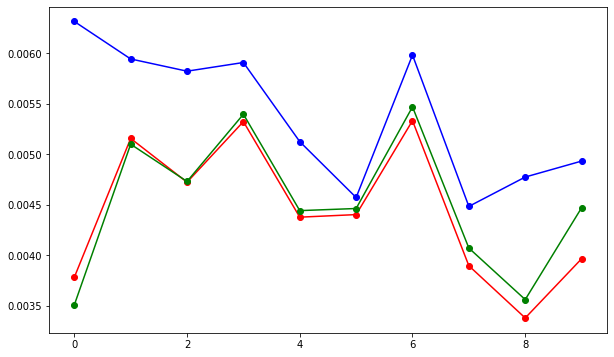

0.04433633911732211 0.0538716276027428 0.04521139812220569


In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.concatenate(archi.get_champions_f()), 'ro-')
ax.plot(scan_pts[best_idx], 'bo-')
ax.plot(np.min(ri_pts, axis=0)[10::10], 'go-')
plt.show()
print(np.concatenate(archi.get_champions_f()).sum(),
      scan_pts[best_idx].sum(), np.min(ri_pts, axis=0)[10::10].sum())

In [183]:
frame_idx = 99
with h5py.File('exp_results/scan_00135/index/135_rot_index_01.h5', 'r') as ri_file:
    idx = np.argmin(ri_file['data/index_pts'][:, frame_idx])
    sol = ri_file['data/index_sol'][idx, frame_idx]
    rb = cbc_dp.RecBasis(ri_file['config/rb_mat'][...])
    f_tol = ri_file['config/f_tol'][...]
    smp_tol = ri_file['config/smp_tol'][...]
    rb_tol = ri_file['config/rb_tol'][...]
    ang_tol = ri_file['config/ang_tol'][...]
rot_tf = cbc_dp.RCBI(streaks=b12_scan[frame_idx], frame_idx=frame_idx, rec_basis=rb,
                     f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol,
                     pen_coeff=1.)

hkl_idxs = rot_tf.hkl_idxs(sol)
kins = rot_tf.kout_exp(sol) - rot_tf.rec_vectors(sol)[:, None]
frame_kin = rot_tf.kin_bounds(sol)
full_kin = (b12_sset.pupil_bounds(0) - sol[:2]) / sol[2]

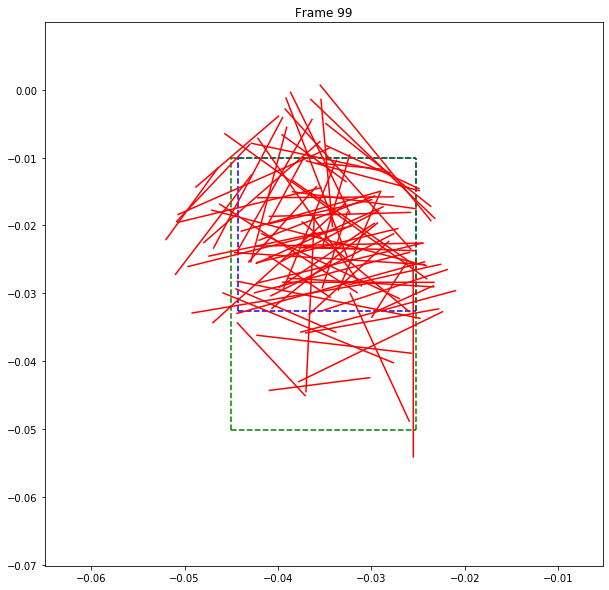

In [184]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[0, 1] * np.ones(50), 'b--')
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[1, 1] * np.ones(50), 'b--')
ax.plot(frame_kin[0, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(frame_kin[1, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[0, 1] * np.ones(50), 'g--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[1, 1] * np.ones(50), 'g--')
ax.plot(full_kin[0, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
ax.plot(full_kin[1, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
for line in kins:
    ax.plot(line[:, 0], line[:, 1], 'r')
offset = 0.02
ax.set_xlim(full_kin[0, 0] - offset, full_kin[1, 0] + offset)
ax.set_ylim(full_kin[0, 1] - offset, full_kin[1, 1] + offset)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()
# plt.savefig('figures/99_pupil_old.pdf')

In [185]:
with h5py.File('exp_results/scan_00135/index/135_rot_index_04.h5', 'r') as ri_file:
    idx = np.argmin(ri_file['data/index_pts'][:, frame_idx])
    sol = ri_file['data/index_sol'][idx, frame_idx]
    rb = cbc_dp.RecBasis(ri_file['config/rb_mat'][...])
    f_tol = ri_file['config/f_tol'][...]
    smp_tol = ri_file['config/smp_tol'][...]
    rb_tol = ri_file['config/rb_tol'][...]
    ang_tol = ri_file['config/ang_tol'][...]
rot_tf = cbc_dp.RCBI(streaks=b12_scan_new[frame_idx], frame_idx=frame_idx, rec_basis=rb,
                     f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol, pen_coeff=1.)

hkl_idxs = rot_tf.hkl_idxs(sol)
kins = rot_tf.kout_exp(sol) - rot_tf.rec_vectors(sol)[:, None]
frame_kin = rot_tf.kin_bounds(sol)
full_kin = (b12_sset.pupil_bounds(0) - sol[:2]) / sol[2]

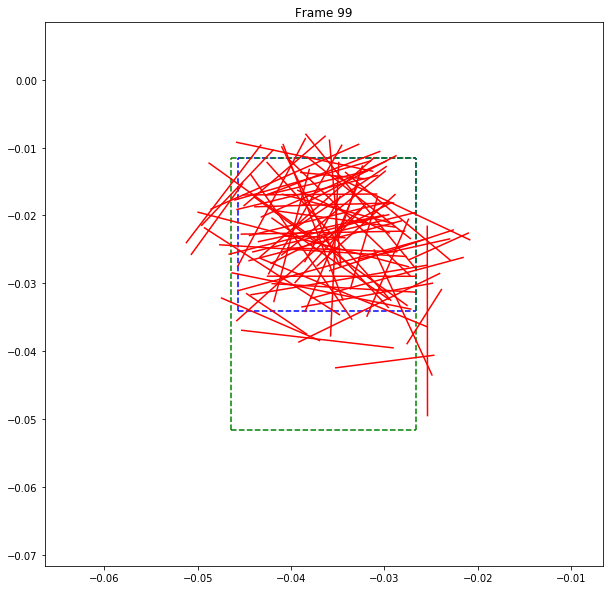

In [186]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[0, 1] * np.ones(50), 'b--')
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[1, 1] * np.ones(50), 'b--')
ax.plot(frame_kin[0, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(frame_kin[1, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[0, 1] * np.ones(50), 'g--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[1, 1] * np.ones(50), 'g--')
ax.plot(full_kin[0, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
ax.plot(full_kin[1, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
for line in kins:
    ax.plot(line[:, 0], line[:, 1], 'r')
offset = 0.02
ax.set_xlim(full_kin[0, 0] - offset, full_kin[1, 0] + offset)
ax.set_ylim(full_kin[0, 1] - offset, full_kin[1, 1] + offset)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()
# plt.savefig('figures/99_pupil_new.pdf')

0.053581006411241194 0.050155169470286 0.048834442560010044 0.04521139812220569 0.04433250959900623


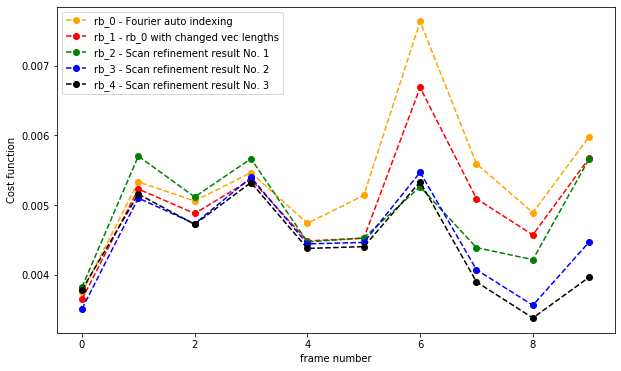

In [187]:
%matplotlib inline
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
with h5py.File('exp_results/scan_00135/index/135_rot_index_00.h5', 'r') as ri_file0:
    ri_pts0 = ri_file0['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_01.h5', 'r') as ri_file1:
    ri_pts1 = ri_file1['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_02.h5', 'r') as ri_file2:
    ri_pts2 = ri_file2['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_03.h5', 'r') as ri_file3:
    ri_pts3 = ri_file3['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_04.h5', 'r') as ri_file4:
    ri_pts4 = ri_file4['data/index_pts'][...]
ax.plot(np.min(ri_pts0[:, 10::10], axis=0), color='orange', marker='o', linestyle='dashed',
        label='rb_0 - Fourier auto indexing')
ax.plot(np.min(ri_pts1[:, 10::10], axis=0), color='red', marker='o', linestyle='dashed',
        label='rb_1 - rb_0 with changed vec lengths')
ax.plot(np.min(ri_pts2[:, 10::10], axis=0), color='green', marker='o', linestyle='dashed',
        label='rb_2 - Scan refinement result No. 1')
ax.plot(np.min(ri_pts3[:, 10::10], axis=0), color='blue', marker='o', linestyle='dashed',
        label='rb_3 - Scan refinement result No. 2')
ax.plot(np.min(ri_pts4[:, 10::10], axis=0), color='black', marker='o', linestyle='dashed',
        label='rb_4 - Scan refinement result No. 3')
ax.legend()
ax.set_xlabel('frame number')
ax.set_ylabel('Cost function')
plt.show()
# plt.savefig('figures/fit_part.pdf')
print(np.min(ri_pts0, axis=0)[10::10].sum(), np.min(ri_pts1, axis=0)[10::10].sum(),
      np.min(ri_pts2, axis=0)[10::10].sum(), np.min(ri_pts3, axis=0)[10::10].sum(),
      np.min(ri_pts4, axis=0)[10::10].sum())

# Sample rotation

In [11]:
eul_ang = index_sol[:, 6:]
thetas = -np.radians(np.arange(101))
rot_mats = np.array([cbc_dp.utils.euler_matrix(ang[0], ang[1], ang[2]) @ b12_exp.rotation_matrix(theta)
                     for theta, ang in zip(thetas, eul_ang)])

In [12]:
rel_rots = []
for rot1, rot0 in zip(rot_mats[1:], rot_mats[:-1]):
    rel_rots.append(rot1 @ np.linalg.inv(rot0))
rel_rots = np.stack(rel_rots)
exp_th = np.arccos((np.trace(rel_rots, axis1=1, axis2=2) - 1) / 2)

In [13]:
ux = rel_rots[:, 2, 1] - rel_rots[:, 1, 2]
uy = rel_rots[:, 0, 2] - rel_rots[:, 2, 0]
uz = rel_rots[:, 1, 0] - rel_rots[:, 0, 1]
u = np.stack([ux, uy, uz], axis=-1)
u = u / np.sqrt((u**2).sum(axis=-1))[:, None]
u_th = np.arccos(u[:, 1])
u_phi = np.arctan2(ux, uz)

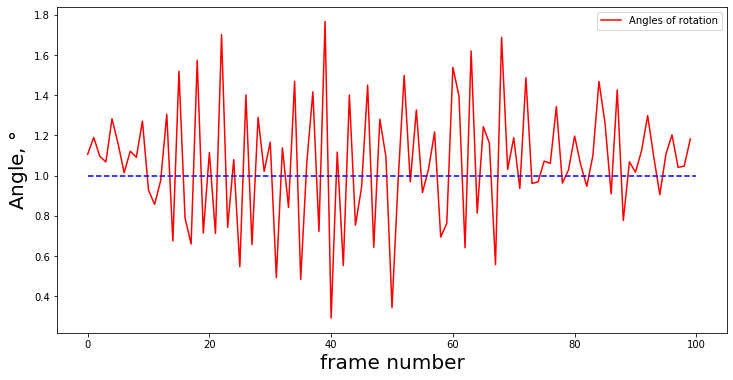

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(np.degrees(exp_th), 'r', label='Angles of rotation')
ax.plot(np.ones(101), 'b--')
ax.legend()
ax.set_xlabel('frame number', fontsize=20)
ax.set_ylabel('Angle, $\degree$', fontsize=20)
plt.show()
# plt.savefig('figures/ang_rot.pdf')

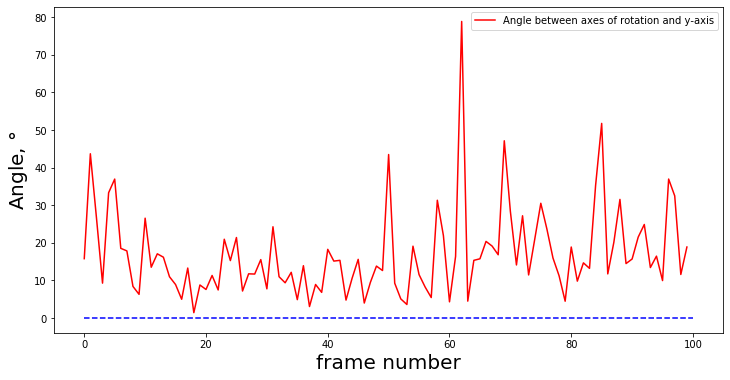

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(np.degrees(np.pi - u_th), 'r', label='Angle between axes of rotation and y-axis')
ax.plot(np.zeros(101), 'b--')
ax.legend()
ax.set_xlabel('frame number', fontsize=20)
ax.set_ylabel('Angle, $\degree$', fontsize=20)
plt.show()
# plt.savefig('figures/ax_rot.pdf')

In [25]:
frame_idx = 89
rec_basis = rec_basis_new.dot(b12_exp.rotation_matrix(-np.radians(frame_idx)).T)
rec_sizes = np.sqrt((rec_basis**2).sum(axis=-1))
start_point = np.concatenate((b12_det_pos_new, rec_sizes, np.zeros(3)))
rot_tf = cbc_dp.RCBI(streaks=b12_scan[frame_idx],
                      num_ap=pupil_size,
                      rec_basis=rec_basis,
                      tol=([0.007, 0.014, 0.06], 0.05, 0.15),
                      pen_coeff=10)
champion = np.concatenate([b12_det_pos_new, rec_sizes, index_sol[frame_idx, 6:]])
m0 = rot_tf.rec_basis(champion)

In [26]:
rec_basis = rec_basis_new.dot(b12_exp.rotation_matrix(-np.radians(frame_idx + 1)).T)
rec_sizes = np.sqrt((rec_basis**2).sum(axis=-1))
start_point = np.concatenate((b12_det_pos_new, rec_sizes, np.zeros(3)))
rot_tf = cbc_dp.RCBI(streaks=b12_scan[frame_idx + 1],
                      num_ap=pupil_size,
                      rec_basis=rec_basis,
                      tol=([0.007, 0.014, 0.06], 0.05, 0.15),
                      pen_coeff=10)
champion = np.concatenate([b12_det_pos_new, rec_sizes, index_sol[frame_idx + 1, 6:]])
rot_tf.rec_basis(champion), m0.dot(rel_rots[frame_idx].T)

(array([[ 0.00075764, -0.04572313,  0.00963788],
        [-0.00170133,  0.0061825 ,  0.03220964],
        [ 0.02943084,  0.00165635,  0.00139729]]),
 array([[ 0.00075764, -0.04572313,  0.00963788],
        [-0.00170133,  0.0061825 ,  0.03220964],
        [ 0.02943084,  0.00165635,  0.00139729]]))

## Intensity estimation

In [35]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t
ctypedef cnp.uint64_t uint_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void streak_mask(float_t[:, ::1] streak, uint8_t[:, ::1] structure, int_t width, uint8_t[:, ::1] mask):
    """
    Generate a streak mask with the given line width and binary dilated with the given structure

    streak - streak's coordinates (x0, y0, x1, y1)
    structure - binary structure
    width - line thickness
    mask - output mask
    """
    cdef:
        float_t slope, thickness, R0, C0, R1 , C1, temp
        int_t r_max = structure.shape[0], c_max = structure.shape[1], i, j, k, y, xx, yy, r, c
        int_t shape_x = mask.shape[0], shape_y = mask.shape[1], k_max = width // 2
    if abs(streak[0, 0] - streak[1, 0]) < abs(streak[0, 1] - streak[1, 1]):
        R0 = streak[0, 0]; C0 = streak[0, 1]; R1 = streak[1, 0]; C1 = streak[1, 1]
        if C0 > C1:
            temp = R0; R0 = R1; R1 = temp
            temp = C0; C0 = C1; C1 = temp
        slope = (R1 - R0) / (C1 - C0)
        for j in range(int(C0), int(C1) + 1):
            y = int(j * slope + (C1 * R0 - C0 * R1) / (C1 - C0))
            for k in range(-k_max, k_max + 1):
                for r in range(r_max):
                    for c in range(c_max):
                        xx = j + r - r_max // 2
                        yy = y + k + c - c_max // 2
                        if yy >= 0 and yy < shape_y and xx >= 0 and xx < shape_x and structure[r, c]:
                            mask[xx, yy] = 1
    else:
        R0 = streak[0, 1]; C0 = streak[0, 0]; R1 = streak[1, 1]; C1 = streak[1, 0]
        if C0 > C1:
            temp = R0; R0 = R1; R1 = temp
            temp = C0; C0 = C1; C1 = temp
        slope = (R1 - R0) / (C1 - C0)
        for j in range(int(C0), int(C1) + 1):
            y = int(j * slope + (C1 * R0 - C0 * R1) / (C1 - C0))
            for k in range(-k_max, k_max + 1):
                for r in range(r_max):
                    for c in range(c_max):
                        xx = y + k + c - c_max // 2
                        yy = j + r - r_max // 2
                        if yy >= 0 and yy < shape_y and xx >= 0 and xx < shape_x and structure[r, c]:
                            mask[xx, yy] = 1

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def i_sigma(float_t[:, :, ::1] streaks, int_t[:, ::1] cor_data, uint_t[:, ::1] background,
            uint8_t[:, ::1] structure, int_t width):
    """
    Return streak's intensity and Poisson noise

    streaks - detected diffraction streaks at the detector plane
    cor_data - background subtracted diffraction data
    background - background image
    structure - binary structure for binary dilation
    width - diffraction streaks width
    """
    cdef:
        int_t aa = streaks.shape[0], a = cor_data.shape[0], b = cor_data.shape[1], cnt, I, ii, i, j
        float_t bgd_mean, bgd_var, bgd_sigma, delta
        uint8_t[:, ::1] mask = np.empty((a, b), dtype=np.uint8)
        float_t[:, ::1] i_sigma = np.empty((aa, 2), dtype=np.float64)
    for ii in range(aa):
        mask[...] = 0
        streak_mask(streaks[ii], structure, width, mask)
        cnt = 0; bgd_mean = 0; bgd_var = 0; I = 0
        for i in range(a):
            for j in range(b):
                if mask[i, j]:
                    cnt += 1
                    delta = (background[i, j] - bgd_mean)
                    bgd_mean += delta / cnt
                    bgd_var += (background[i, j] - bgd_mean) * delta
                    I += cor_data[i, j]
        bgd_sigma = max(bgd_mean * cnt, bgd_var)
        i_sigma[ii, 0] = I
        i_sigma[ii, 1] = sqrt(I + bgd_sigma)
    return np.asarray(i_sigma)

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def i_sigma_norm(float_t[:, :, ::1] streaks, float_t[:, :, ::1] source_streaks, int_t[:, ::1] cor_data,
                 uint_t[:, ::1] background, uint8_t[:, ::1] structure, int_t width):
    """
    Return diffraction reflection's intensity and Poisson noise of a frame

    streaks - detected diffraction streaks at the detector plane
    source_streaks - source streaks at the detector plane
    cor_data - background subtracted diffraction pattern image
    background - background image
    structure - binary structure for binary dilation
    width - diffraction streaks width
    """
    cdef:
        int_t aa = streaks.shape[0], a = cor_data.shape[0], b = cor_data.shape[1]
        int_t cnt = 0, s_cnt = 0, ii, i, j
        float_t bgd_mean, bgd_var, s_mean, s_var, I, bgd_sigma, delta
        uint8_t[:, ::1] mask = np.empty((a, b), dtype=np.uint8)
        uint8_t[:, ::1] s_mask = np.empty((a, b), dtype=np.uint8)
        float_t[:, ::1] i_sigma = np.empty((aa, 2), dtype=np.float64)
    for ii in range(aa):
        mask[...] = 0; s_mask[...] = 0
        streak_mask(streaks[ii], structure, width, mask)
        streak_mask(source_streaks[ii], structure, width, s_mask)
        cnt = 0; s_cnt = 0
        bgd_mean = 0; bgd_var = 0; I = 0; s_mean = 0; s_var = 0
        for i in range(a):
            for j in range(b):
                if mask[i, j]:
                    cnt += 1
                    delta = (background[i, j] - bgd_mean)
                    bgd_mean += delta / cnt
                    bgd_var += (background[i, j] - bgd_mean) * delta
                    I += cor_data[i, j]
                if s_mask[i, j]:
                    s_cnt += 1
                    delta = (background[i, j] - s_mean)
                    s_mean += delta / s_cnt
                    s_var += (background[i, j] - s_mean) * delta
        bgd_sigma = max(bgd_mean * cnt, bgd_var)
        i_sigma[ii, 0] = I / (s_mean * s_cnt)
        i_sigma[ii, 1] = sqrt(I + bgd_sigma + s_var)
    return np.asarray(i_sigma)

In [7]:
b12_sset = cbc_dp.ScanSetup.import_ini('b12_geom_02.ini')
with h5py.File(cor_path.format(135), 'r') as f135:
    b12_scan_new = cbc_dp.ScanStreaks(raw_lines=f135['streaks/lines'][...],
                                      exp_set=b12_sset,
                                      frame_idxs=f135['streaks/frame_idxs'][...])

In [192]:
with h5py.File('exp_results/scan_00135/index/135_rot_index_01.h5', 'r') as ri_file:
    ri_sol = ri_file['data/index_sol'][...]
    ri_pts = ri_file['data/index_pts'][...]
    rb = cbc_dp.RecBasis(ri_file['config/rb_mat'][...])
    f_tol = ri_file['config/f_tol'][...]
    smp_tol = ri_file['config/smp_tol'][...]
    rb_tol = ri_file['config/rb_tol'][...]
    ang_tol = ri_file['config/ang_tol'][...]
idxs = (np.argmin(ri_pts, axis=0), np.arange(ri_sol.shape[1]))
ri_sol = ri_sol[idxs]

In [193]:
kin_list, hkl_list, kout_list = [], [], []
for frame_idx, (rot_ch, b12_frame) in enumerate(zip(ri_sol, b12_scan)):
    rot_tf = cbc_dp.RCBI(streaks=b12_frame, frame_idx=frame_idx, rec_basis=rb,
                         f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    kout_list.append(rot_tf.kout_exp(rot_ch))
    hkl_list.append(rot_tf.hkl_idxs(rot_ch))
    kin_list.append(rot_tf.kout_exp(rot_ch) - rot_tf.rec_vectors(rot_ch)[:, None])
kout_arr = np.concatenate(kout_list)
kin_arr = np.concatenate(kin_list)
hkl_arr = np.concatenate(hkl_list)

In [194]:
c0_list, c1_list = [], []
for i0, i1, i2 in zip(b12_scan_new.idxs[:-2], b12_scan_new.idxs[1:-1], b12_scan_new.idxs[2:]):
    hkl0, hkl1 = hkl_arr[i0:i1], hkl_arr[i1:i2]
    c0, c1 = np.where((hkl0[:, None] == hkl1[None, :]).all(axis=-1))
    c0_list.append(c0)
    c1_list.append(c1)

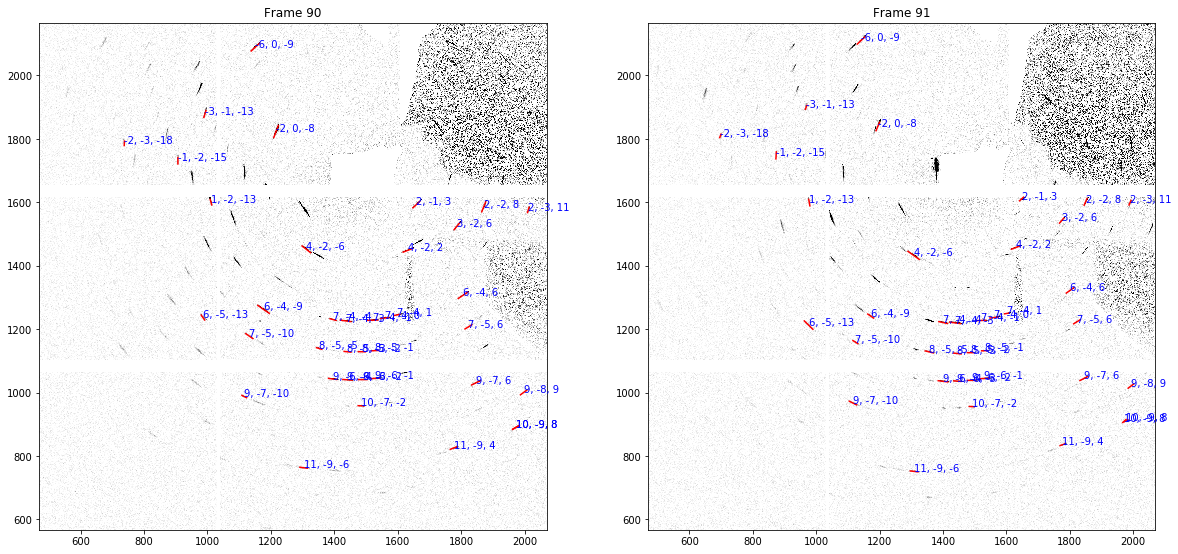

In [156]:
%matplotlib inline
frame_idx = 90
hkl0 = hkl_arr[b12_scan.idxs[frame_idx]:b12_scan.idxs[frame_idx + 1]][c0_list[frame_idx]]
hkl1 = hkl_arr[b12_scan.idxs[frame_idx + 1]:b12_scan.idxs[frame_idx + 2]][c1_list[frame_idx]]
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[frame_idx], vmin=0, vmax=50, cmap='gray_r')
axes[1].imshow(b12_cor_data[frame_idx + 1], vmin=0, vmax=50, cmap='gray_r')
for hkl, line in zip(hkl0, b12_scan[frame_idx].raw_lines[c0_list[frame_idx]]):
    axes[0].plot(line[:, 0], line[:, 1], 'r')
    axes[0].text(line[..., 0].mean(), line[..., 1].mean(),
                 '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color='b')
for hkl, line in zip(hkl1, b12_scan[frame_idx + 1].raw_lines[c1_list[frame_idx]]):
    axes[1].plot(line[:, 0], line[:, 1], 'r')
    axes[1].text(line[..., 0].mean(), line[..., 1].mean(),
                 '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color='b')
for ax, frame_idx in zip(axes, [frame_idx, frame_idx + 1]):
    ax.set_xlim(470, 2070)
    ax.set_ylim(567, 2167)
    ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

# Frame streaks merging

In [199]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void dot_vector(float_t[::1] vec, float_t[:, ::1] rot_mat, float_t[::1] output) nogil:
    """
    Rotate a 3d vector by the rotation matrix and write it to output vector
    """
    output[0] = rot_mat[0, 0] * vec[0] + rot_mat[0, 1] * vec[1] + rot_mat[0, 2] * vec[2]
    output[1] = rot_mat[1, 0] * vec[0] + rot_mat[1, 1] * vec[1] + rot_mat[1, 2] * vec[2]
    output[2] = rot_mat[2, 0] * vec[0] + rot_mat[2, 1] * vec[1] + rot_mat[2, 2] * vec[2]

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void dot_matrix(float_t[:, ::1] mat, float_t[:, ::1] rot_mat, float_t[:, ::1] output) nogil:
    """
    Rotate a 3x3 matrix by the rotation matrix and write it to output vector
    """
    dot_vector(mat[0], rot_mat, output[0])
    dot_vector(mat[1], rot_mat, output[1])
    dot_vector(mat[2], rot_mat, output[2])

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef float_t frame_distance(float_t x, float_t y, float_t[:, ::1] frame) nogil:
    """
    Return distance to a frame for a point lying outside the frame
    """
    cdef:
        float_t dx = 0, dy = 0
    if x > frame[1, 0]:
        dx += (x - frame[1, 0])
    if y > frame[1, 1]:
        dy += (y - frame[1, 1])
    if x < frame[0, 0]:
        dx += (frame[0, 0] - x)
    if y < frame[0, 1]:
        dy += (frame[0, 1] - y)
    return sqrt(dx**2 + dy**2)

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef float_t fit_streak(float_t[::1] vot_vec, float_t[:, ::1] kout_exp,
                        float_t[:, ::1] kin, float_t pen_coeff) nogil:
    """
    Return fitness value for a streak

    vot_vec - voting reciprocal lattice vectors
    kout_exp - experimental outcoming wavevectors
    kin = [[kin_x_min, kin_y_min], [kin_x_max, kin_y_max]] - lens' pupil bounds
    pen_coeff - penalty coefficient
    """
    cdef:
        float_t rec_abs = sqrt(vot_vec[0]**2 + vot_vec[1]**2 + vot_vec[2]**2)
        float_t k0_x = kout_exp[0, 0] - vot_vec[0], k1_x = kout_exp[1, 0] - vot_vec[0]
        float_t k0_y = kout_exp[0, 1] - vot_vec[1], k1_y = kout_exp[1, 1] - vot_vec[1]
        float_t k0_z = kout_exp[0, 2] - vot_vec[2], k1_z = kout_exp[1, 2] - vot_vec[2]
        float_t n_x, n_y, n_z, 
        float_t src_th, src_phi, prod
        float_t fit_x, fit_y, fit, d0, d1
    if rec_abs != 0:
        src_th = acos(-vot_vec[2] / rec_abs) - acos(rec_abs / 2)
        src_phi = atan2(vot_vec[1], vot_vec[0])
        n_x = k0_y * k1_z - k0_z * k1_y
        n_y = k0_z * k1_x - k0_x * k1_z
        n_z = k0_x * k1_y - k0_y * k1_x
        prod = (k0_x * n_x + k0_y * n_y + (k0_z - 1) * n_z) / (n_x**2 + n_y**2 + n_z**2)
        fit_x = prod * n_x + sin(src_th) * cos(src_phi)
        fit_y = prod * n_y + sin(src_th) * sin(src_phi)
        fit = sqrt(fit_x**2 + fit_y**2)
    else:
        fit = 0

    d0 = frame_distance(k0_x, k0_y, kin)
    d1 = frame_distance(k1_x, k1_y, kin)
    fit += pen_coeff * (d0 + d1)
    return fit

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def reduce_frame(float_t[:, :, ::1] kout_exp, float_t[:, ::1] hkl, float_t[:, ::1] rb_mat,
                 float_t[:, ::1] kin, float_t pen_coeff):
    """
    Exclude multiple streaks in a frame with the same hkl index
    kout_exp - experimental outcoming wavevectors
    hkl - the hkl indices of the diffraction reflections
    rb_mat - reciprocal lattice basis vectors matrix
    kin = [[kin_x_min, kin_y_min], [kin_x_max, kin_y_max]] - lens' pupil bounds
    pen_coeff - penalty coefficient
    """
    cdef:
        int_t a = kout_exp.shape[0], ii = 0, i, j
        float_t fit, new_fit
        float_t[::1] rec_vec = np.empty(3, dtype=np.float64)
        int_t[::1] idxs = np.empty(a, dtype=np.int64)
        uint8_t[::1] mask = np.zeros(a, dtype=np.uint8)
    for i in range(a):
        if not mask[i]:
            mask[i] = 1; idxs[ii] = i
            dot_vector(hkl[i], rb_mat, rec_vec)
            fit = fit_streak(rec_vec, kout_exp[i], kin, pen_coeff)
            for j in range(a):
                if j != i and hkl[j, 0] == hkl[i, 0] and hkl[j, 1] == hkl[i, 1] and hkl[j, 2] == hkl[i, 2]:
                    mask[j] = 1
                    dot_vector(hkl[j], rb_mat, rec_vec)
                    new_fit = fit_streak(rec_vec, kout_exp[j], kin, pen_coeff)
                    if new_fit < fit:
                        idxs[ii] = j; fit = new_fit
            ii += 1
    return np.asarray(idxs[:ii]), np.asarray(mask)

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def reduce_frame(float_t[:, :, ::1] kout_exp, float_t[:, ::1] hkl, float_t[:, ::1] rb_mat,
                 float_t[:, ::1] kin, float_t pen_coeff):
    """
    Exclude multiple streaks in a frame with the same hkl index
    kout_exp - experimental outcoming wavevectors
    hkl - the hkl indices of the diffraction reflections
    rb_mat - reciprocal lattice basis vectors matrix
    kin = [[kin_x_min, kin_y_min], [kin_x_max, kin_y_max]] - lens' pupil bounds
    pen_coeff - penalty coefficient
    """
    cdef:
        int_t a = kout_exp.shape[0], idx = 0, i, j
        float_t fit, new_fit
        float_t[::1] rec_vec = np.empty(3, dtype=np.float64)
        int_t[::1] ri = np.empty(a, dtype=np.int64)
        uint8_t[::1] mask = np.zeros(a, dtype=np.uint8)
    for i in range(a):
        if not mask[i]:
            mask[i] = 1; ri[idx] = i
            dot_vector(hkl[i], rb_mat, rec_vec)
            fit = fit_streak(rec_vec, kout_exp[i], kin, pen_coeff)
            for j in range(a):
                if j != i and hkl[j, 0] == hkl[i, 0] and hkl[j, 1] == hkl[i, 1] and hkl[j, 2] == hkl[i, 2]:
                    mask[j] = 1
                    dot_vector(hkl[j], rb_mat, rec_vec)
                    new_fit = fit_streak(rec_vec, kout_exp[j], kin, pen_coeff)
                    if new_fit < fit:
                        ri[idx] = j; fit = new_fit
            idx += 1
    return np.asarray(ri[:idx])

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def reduce_scan(float_t[:, :, ::1] kout_exp, float_t[:, ::1] hkl, float_t[:, :, ::1] rb_mat,
                float_t[:, :, ::1] kin, int_t[::1] idxs, float_t pen_coeff):
    """
    Exclude multiple streaks in a frame with the same hkl index
    kout_exp - experimental outcoming wavevectors
    hkl - the hkl indices of the diffraction reflections
    rb_mat - reciprocal lattice basis vectors matrix
    kin = [[kin_x_min, kin_y_min], [kin_x_max, kin_y_max]] - lens' pupil bounds
    pen_coeff - penalty coefficient
    """
    cdef:
        int_t aa = kout_exp.shape[0], a = idxs.shape[0] - 1, idx = 0, ii, i, j
        float_t fit, new_fit
        float_t[::1] rec_vec = np.empty(3, dtype=np.float64)
        int_t[::1] ri = np.empty(aa, dtype=np.int64)
        uint8_t[::1] mask = np.zeros(aa, dtype=np.uint8)
    for i in range(a):
        for ii in range(idxs[i], idxs[i + 1]):
            if not mask[ii]:
                mask[idx] = 1; idxs[idx] = i
                dot_vector(hkl[i], rb_mat[i], rec_vec)
                fit = fit_streak(rec_vec, kout_exp[ii], kin[i], pen_coeff)
                for j in range(idxs[i], idxs[i + 1]):
                    if j != ii and hkl[j, 0] == hkl[ii, 0] and hkl[j, 1] == hkl[ii, 1] and hkl[j, 2] == hkl[ii, 2]:
                        mask[j] = 1
                        dot_vector(hkl[j], rb_mat[i], rec_vec)
                        new_fit = fit_streak(rec_vec, kout_exp[j], kin[i], pen_coeff)
                        if new_fit < fit:
                            idxs[idx] = j; fit = new_fit
                idx += 1
    return np.asarray(idxs[:idx])

In [200]:
idxs_list = []
for frame_idx, (rot_ch, b12_frame) in enumerate(zip(ri_sol, b12_scan_new)):
    rot_tf = cbc_dp.RCBI(streaks=b12_frame, frame_idx=frame_idx, rec_basis=rb,
                         f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    idxs_list.append(reduce_frame(rot_tf.kout_exp(rot_ch), rot_tf.hkl_idxs(rot_ch).astype(np.float64),
                                  rot_tf.rb_mat(rot_ch), rot_tf.kin_bounds(rot_ch), 1.))

In [203]:
b12_scan_r = cbc_dp.ScanStreaks.import_series([b12_frame[idxs] for b12_frame, idxs in zip(b12_scan, idxs_list)])
b12_scan.size, b12_scan_r.size

(13099, 12232)

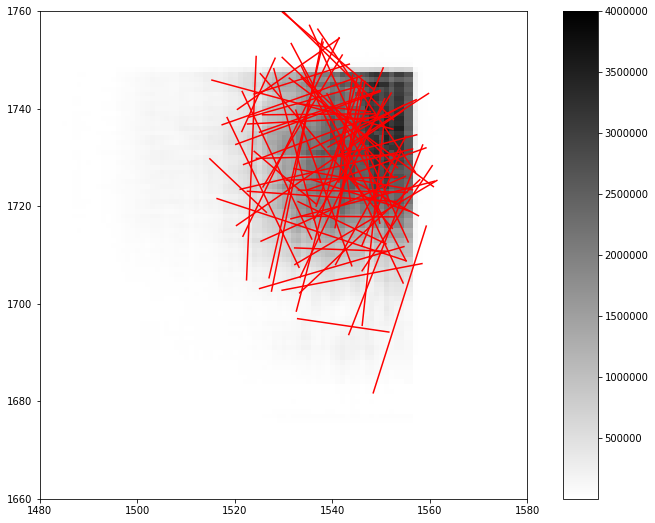

In [161]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

frame_idx = 100
rot_tf = cbc_dp.RCBI(streaks=b12_scan_r[frame_idx], frame_idx=frame_idx, rec_basis=rb,
                     f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
kin_frame = rot_tf.kout_exp(ri_sol[frame_idx]) - rot_tf.rec_vectors(ri_sol[frame_idx])[:, None]
det_frame = rot_tf.det_kin(kin_frame[..., 0], kin_frame[..., 1], ri_sol[frame_idx])
frame_kin = rot_tf.kin_bounds(ri_sol[frame_idx])
full_kin = (b12_sset.pupil_bounds(frame_idx) - ri_sol[frame_idx, :2]) / ri_sol[frame_idx, 2]

%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.imshow(b12_bgd[frame_idx], vmin=400, vmax=4000000, cmap='gray_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.5)
fig.colorbar(im, cax=cax)
for line in det_frame:
    ax.plot(line[:, 0], line[:, 1], 'r')
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[0, 1] * np.ones(50), 'b--')
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[1, 1] * np.ones(50), 'b--')
ax.plot(frame_kin[0, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(frame_kin[1, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[0, 1] * np.ones(50), 'g--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[1, 1] * np.ones(50), 'g--')
ax.plot(full_kin[0, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
ax.plot(full_kin[1, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
ax.set_xlim(1480, 1580)
ax.set_ylim(1660, 1760)
plt.show()
# plt.savefig('figures/source_streaks_r.pdf')

# Streaks merging

In [162]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t
ctypedef cnp.uint64_t uint_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def merge_cython(int_t[:, ::1] hkl_arr, float_t[::1] i_arr, float_t[::1] s_arr):
    cdef:
        int_t a = hkl_arr.shape[0], ii = 0, i, j, k, cnt, flag
        float_t i_mean, i_var, delta, w, w2
        uint8_t[::1] mask = np.zeros(a, dtype=np.uint8)
        int_t[::1] cnts = np.empty(a, dtype=np.int64)
        int_t[:, ::1] hkl_m = np.empty((a, 3), dtype=np.int64)
        float_t[::1] i_m = np.empty(a, dtype=np.float64)
        float_t[::1] s_m = np.empty(a, dtype=np.float64)
    for i in range(a):
        if not mask[i]:
            hkl_m[ii] = hkl_arr[i]; mask[i] = 1; cnt = 1
            i_mean = i_arr[i]; i_var = 0; w = s_arr[i]**-2; w2 = s_arr[i]**-4
            for k in range(a):
                if k != i and hkl_arr[k, 0] == hkl_m[ii, 0] and hkl_arr[k, 1] == hkl_m[ii, 1] and hkl_arr[k, 2] == hkl_m[ii, 2]:
                    mask[k] = 1; cnt += 1; w += s_arr[k]**-2; w2 += s_arr[k]**-4
                    delta = i_arr[k] - i_mean
                    i_mean += delta * s_arr[k]**-2 / w
                    i_var += s_arr[k]**-2 * delta * (i_arr[k] - i_mean)
            i_m[ii] = i_mean; cnts[ii] = cnt
            if cnt > 1:
                s_m[ii] = sqrt(i_var / (w - w2 / w));
            else:
                s_m[ii] = s_arr[i]
            ii += 1
    return np.asarray(hkl_m[:ii]), np.asarray(cnts[:ii]), np.asarray(i_m[:ii]), np.asarray(s_m[:ii])

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def symmetry_merge(int_t[:, :, ::1] rot_ops, int_t[:, ::1] hkl_arr, float_t[::1] i_arr, float_t[::1] s_arr):
    cdef:
        int_t a = hkl_arr.shape[0], b = rot_ops.shape[0], ii = 0, i, j, k, cnt, flag
        float_t i_mean, i_var, delta, w, w2
        uint8_t[::1] mask = np.zeros(a, dtype=np.uint8)
        int_t[::1] cnts = np.empty(a, dtype=np.int64)
        int_t[:, ::1] hkl_m = np.empty((a, 3), dtype=np.int64)
        int_t[:, ::1] sym_hkls = np.empty((b, 3), dtype=np.int64)
        float_t[::1] i_m = np.empty(a, dtype=np.float64)
        float_t[::1] s_m = np.empty(a, dtype=np.float64)
    for i in range(a):
        if not mask[i]:
            hkl_m[ii] = hkl_arr[i]; mask[i] = 1; cnt = 1
            i_mean = i_arr[i]; i_var = 0; w = s_arr[i]**-2; w2 = s_arr[i]**-4
            for j in range(b):
                sym_hkls[j, 0] = (hkl_m[ii, 0] * rot_ops[j, 0, 0] +
                                  hkl_m[ii, 1] * rot_ops[j, 0, 1] +
                                  hkl_m[ii, 2] * rot_ops[j, 0, 2])
                sym_hkls[j, 1] = (hkl_m[ii, 0] * rot_ops[j, 1, 0] +
                                  hkl_m[ii, 1] * rot_ops[j, 1, 1] +
                                  hkl_m[ii, 2] * rot_ops[j, 1, 2])
                sym_hkls[j, 2] = (hkl_m[ii, 0] * rot_ops[j, 2, 0] +
                                  hkl_m[ii, 1] * rot_ops[j, 2, 1] +
                                  hkl_m[ii, 2] * rot_ops[j, 2, 2])
            for k in range(a):
                if k != i:
                    flag = 0
                    for j in range(b):
                        flag += (sym_hkls[j, 0] == hkl_arr[k, 0] and
                                 sym_hkls[j, 1] == hkl_arr[k, 1] and
                                 sym_hkls[j, 2] == hkl_arr[k, 2])
                    if flag:
                        mask[k] = 1; cnt += 1; w += s_arr[k]**-2; w2 += s_arr[k]**-4
                        delta = i_arr[k] - i_mean
                        i_mean += delta * s_arr[k]**-2 / w
                        i_var += s_arr[k]**-2 * delta * (i_arr[k] - i_mean)
            i_m[ii] = i_mean; cnts[ii] = cnt
            if cnt > 1:
                s_m[ii] = sqrt(i_var / (w - w2 / w));
            else:
                s_m[ii] = s_arr[i]
            ii += 1
    return np.asarray(hkl_m[:ii]), np.asarray(cnts[:ii]), np.asarray(i_m[:ii]), np.asarray(s_m[:ii])

In [204]:
def res_sort(rec_basis, hkl_m, cnts, i_m, s_m, wl=wavelength):
    rec_vec = hkl_m.dot(rec_basis)
    rec_abs = (rec_vec**2).sum(axis=-1) / wl * 1e-7
    sort_idxs = np.argsort(rec_abs)
    return hkl_m[sort_idxs], cnts[sort_idxs], i_m[sort_idxs], s_m[sort_idxs], np.sort(rec_abs)

In [216]:
is_list, hkl_list = [], []
for frame_idx, b12_frame, rot_ch in zip(b12_scan_r.frames, b12_scan_r, ri_sol):
    rot_tf = cbc_dp.RCBI(b12_frame, frame_idx=frame_idx, rec_basis=rb, f_tol=f_tol,
                         smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    kin_frame = rot_tf.kout_exp(rot_ch) - rot_tf.rec_vectors(rot_ch)[:, None]
    det_frame = rot_tf.det_kin(kin_frame[..., 0], kin_frame[..., 1], rot_ch)
    is_list.append(i_sigma_norm(b12_frame.raw_lines, det_frame, b12_cor_data[frame_idx],
                           b12_bgd[frame_idx], cbc_dp.utils.STRUCT, 5))
    hkl_list.append(rot_tf.hkl_idxs(rot_ch))
i_arr = np.concatenate([is_frame[..., 0] for is_frame in is_list])
s_arr = np.concatenate([is_frame[..., 1] for is_frame in is_list])
hkl_arr = np.concatenate(hkl_list)

In [213]:
is_list, hkl_list = [], []
for frame_idx, b12_frame, rot_ch in zip(b12_scan_r.frames, b12_scan_r, ri_sol):
    rot_tf = cbc_dp.RCBI(b12_frame, frame_idx=frame_idx, rec_basis=rb, f_tol=f_tol,
                         smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    is_list.append(i_sigma(b12_frame.raw_lines, b12_cor_data[frame_idx],
                           b12_bgd[frame_idx], cbc_dp.utils.STRUCT, 5))
    hkl_list.append(rot_tf.hkl_idxs(rot_ch))
i_arr = np.concatenate([is_frame[..., 0] for is_frame in is_list])
s_arr = np.concatenate([is_frame[..., 1] for is_frame in is_list])
hkl_arr = np.concatenate(hkl_list)

In [165]:
import spglib

h_num = 115
rot_ops = spglib.get_symmetry_from_database(h_num)['rotations'].astype(np.int64)

In [166]:
hkl_m, cnts_m, i_m, s_m = merge_cython(hkl_arr, i_arr, s_arr)
hkl_sym, cnts_sym, i_sym, s_sym = symmetry_merge(rot_ops, hkl_arr, i_arr, s_arr)
hkl_m.shape, hkl_sym.shape

((5421, 3), (3798, 3))

In [167]:
hkl_m, cnts_m, i_m, s_m, rs = res_sort(rb.rb_mat, hkl_m, cnts_m, i_m, s_m)
hkl_sym, cnts_sym, i_sym, s_sym, rs_sym = res_sort(rb.rb_mat, hkl_sym, cnts_sym, i_sym, s_sym)

In [168]:
i_idx, f_idx = 1000, 1030
for hkl, cnt, i, s, r in zip(hkl_m[i_idx:f_idx], cnts_m[i_idx:f_idx], i_m[i_idx:f_idx], s_m[i_idx:f_idx], rs[i_idx:f_idx]):
    print('{0[0]:4d},{0[1]:4d},{0[2]:4d}:{1:6d}{2:16.4e}{3:16.4e}{4:8.2f}'.format(hkl, cnt, i, s, r))

   5,  -2,   5:     2      2.8092e-06      4.2556e-07    0.10
  -2,   4,   8:     1      1.8681e-05      1.3477e+07    0.10
   2,  -4,  -8:     1      1.6378e-05      2.5339e+07    0.10
   1,  -3,  -9:     1      5.5931e-06      2.1226e+07    0.10
   4,   6,   3:     1      3.7268e-06      1.2227e+07    0.10
  -4,  -6,  -3:     1      3.6213e-06      1.4638e+07    0.10
   4,  -2,   7:     2      5.9930e-06      4.7140e-07    0.10
   5,   2,   5:     2      2.8127e-06      2.3604e-07    0.10
  -5,  -2,  -5:     3      2.0999e-06      4.0629e-07    0.10
  -6,  -1,  -1:     7      3.4071e-05      1.8047e-05    0.10
  -2,  -4,  -8:     2      1.7639e-05      8.6967e-06    0.10
   0,   6,   7:     1      3.0433e-05      1.0057e+07    0.10
   0,  -6,  -7:     1      1.6812e-05      1.1239e+07    0.10
  -6,   1,   1:     2      3.2852e-05      7.1289e-06    0.10
  -1,  -3,  -9:     2      1.6700e-05      2.4553e-05    0.10
  -5,  -5,  -1:     2      7.4736e-06      8.0080e-07    0.10
  -2,   

In [169]:
max_idx = 40
for hkl, cnt, i, s, r in zip(hkl_sym[:max_idx], cnts_sym[:max_idx], i_sym[:max_idx], s_sym[:max_idx], rs_sym[:max_idx]):
    print('{0[0]:4d},{0[1]:4d},{0[2]:4d}:{1:6d}{2:16.4e}{3:16.4e}{4:8.2f}'.format(hkl, cnt, i, s, r))

   0,   1,   1:     1      1.1468e-03      2.9558e+07    0.00
  -1,   0,  -1:     3      8.5539e-05      3.0465e-05    0.00
  -1,  -1,   0:     3      2.3445e-03      2.1435e-03    0.00
   0,   0,   2:     3      1.3386e-02      1.0003e-02    0.00
  -1,  -1,  -1:     3      3.8500e-04      5.8659e-05    0.01
   1,   1,   1:     1      3.6618e-04      8.5795e+10    0.01
   0,   1,   2:     1      2.9811e-05      8.1508e+06    0.01
   0,   2,   1:     2      1.0396e-03      1.2533e-05    0.01
   1,   0,   2:     5      8.0910e-05      2.0037e-05    0.01
  -1,  -2,   0:     2      5.9613e-03      4.1932e-03    0.01
  -1,  -1,  -2:     4      8.3976e-04      1.0398e-04    0.01
   1,   1,   2:     1      6.2830e-04      2.4167e+07    0.01
   1,   2,   1:     2      7.1669e-06      2.2868e-06    0.01
  -1,   2,   1:     4      1.3040e-05      5.0919e-06    0.01
   0,   0,   3:     2      9.1174e-03      6.3954e-03    0.01
   0,  -2,  -2:     1      5.9592e-02      6.0598e+03    0.01
   0,   

In [170]:
d_res = 0.1
limits = d_res * np.arange(rs_sym.min() // d_res, rs_sym.max() // d_res + 1)
sects = np.unique(np.searchsorted(limits, rs_sym), return_index=True)[1]
hkl_list = np.split(hkl_sym, indices_or_sections=sects[1:])
cnts_list = np.split(cnts_sym, indices_or_sections=sects[1:])
i_list = np.split(i_sym, indices_or_sections=sects[1:])
s_list = np.split(s_sym, indices_or_sections=sects[1:])
abs_list = np.split(rs_sym, indices_or_sections=sects[1:])

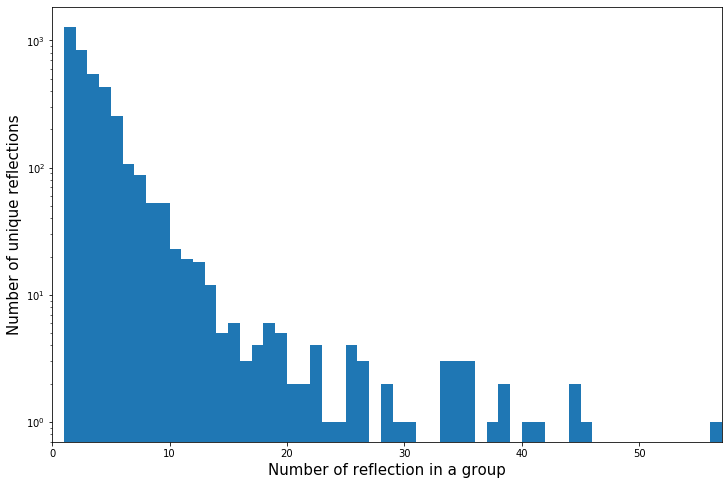

In [171]:
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.hist(cnts_sym, bins=np.arange(0, cnts_sym.max() + 1), log=True)
ax.set_xlabel('Number of reflection in a group', fontsize=15)
ax.set_ylabel('Number of unique reflections', fontsize=15)
ax.set_xlim(0, cnts_sym.max())
plt.show()
# plt.savefig('figures/hkl_hist.pdf')

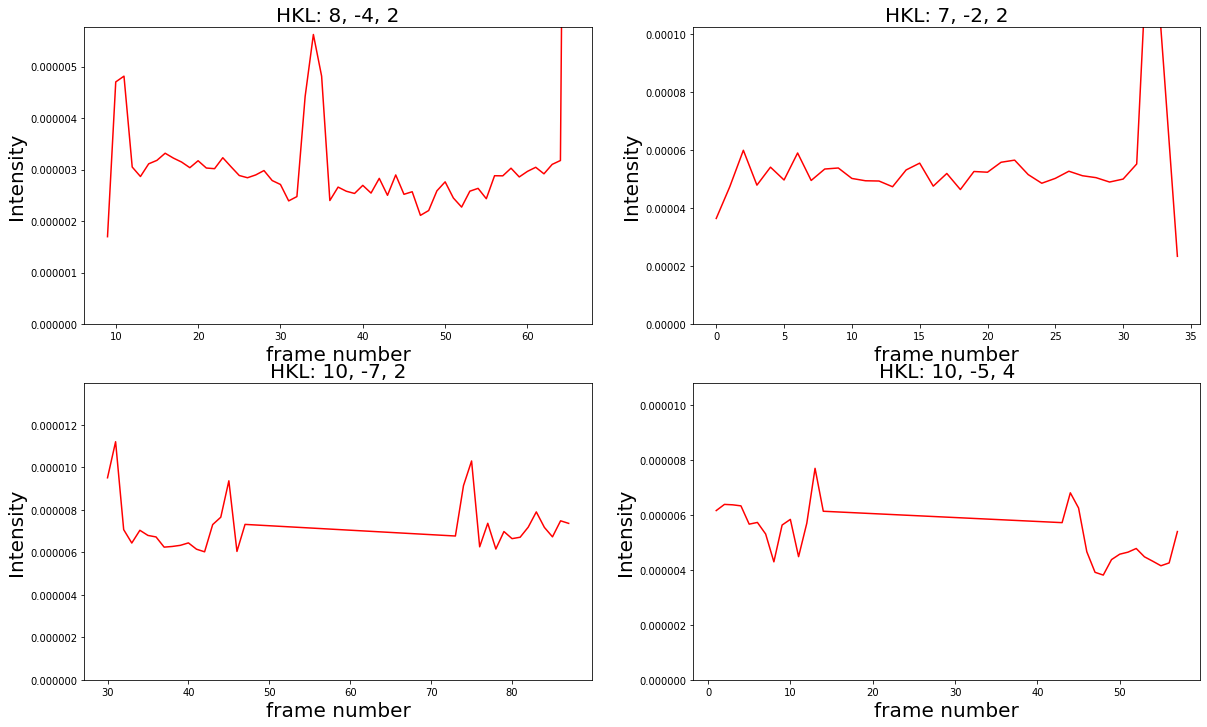

In [217]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
sort_idxs = np.argsort(cnts_m)[::-1]
for idx, ax in zip([0, 5, 10, 15], axes.ravel()):
    hkl_max = hkl_m[sort_idxs[idx]]
    idxs = np.where((hkl_arr == hkl_max).all(axis=-1))
    ax.plot(b12_scan_r.frame_idxs[idxs], i_arr[idxs], 'r')
    ax.set_ylim(0, 2 * np.median(i_arr[idxs]))
    ax.set_xlabel('frame number', fontsize=20)
    ax.set_ylabel('Intensity', fontsize=20)
    ax.set_title('HKL: {0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl_max), fontsize=20)
# plt.show()
plt.savefig('figures/hkl_int_norm.pdf')

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
idxs = np.where((hkl_arr == hkl_max).all(axis=-1))[0][1:]
lines = b12_scan_r.raw_lines[idxs]
for line in lines:
    ax.plot(line[:, 0], line[:, 1], 'r')
ax.imshow((b12_cor_data[b12_scan_r.frame_idxs[idxs]] * b12_streaks_mask[b12_scan_r.frame_idxs[idxs]]).sum(axis=0),
          vmin=0, vmax=100)
offset = 150
ax.set_xlim(lines[..., 0].min() - offset, lines[..., 0].max() + offset)
ax.set_ylim(lines[..., 1].min() - offset, lines[..., 1].max() + offset)
plt.show()

In [98]:
hkl1, _, i1_m, _ = symmetry_merge(rot_ops=rot_ops,
                                  hkl_arr=np.ascontiguousarray(hkl_arr[::2]),
                                  i_arr=np.ascontiguousarray(i_arr[::2]),
                                  s_arr=np.ascontiguousarray(s_arr[::2]))
hkl2, _, i2_m, _ = symmetry_merge(rot_ops=rot_ops,
                                  hkl_arr=np.ascontiguousarray(hkl_arr[1::2]),
                                  i_arr=np.ascontiguousarray(i_arr[1::2]),
                                  s_arr=np.ascontiguousarray(s_arr[1::2]))
cidxs1, cidxs2 = np.where((hkl1[:, None] == hkl2[None, :]).all(axis=-1))
i1_c, i2_c = i1_m[cidxs1], i2_m[cidxs2]
r_split = np.abs(i1_c - i2_c).sum() / (i1_c + i2_c).sum() * np.sqrt(2)
print(r_split)

0.4662487630989815


In [84]:
hkl_mult = hkl_sym[cnts_sym > 11]
idxs_mult = np.where((hkl_arr[:, None] == hkl_mult[None, :]).all(axis=-1).any(axis=1))
hkl_mult, i_mult, s_mult = hkl_arr[idxs_mult], i_arr[idxs_mult], s_arr[idxs_mult]

In [85]:
hkl1, _, i1_m, _ = symmetry_merge(rot_ops=rot_ops,
                                  hkl_arr=np.ascontiguousarray(hkl_mult[::2]),
                                  i_arr=np.ascontiguousarray(i_mult[::2]),
                                  s_arr=np.ascontiguousarray(s_mult[::2]))
hkl2, _, i2_m, _ = symmetry_merge(rot_ops=rot_ops,
                                  hkl_arr=np.ascontiguousarray(hkl_mult[1::2]),
                                  i_arr=np.ascontiguousarray(i_mult[1::2]),
                                  s_arr=np.ascontiguousarray(s_mult[1::2]))
cidxs1, cidxs2 = np.where((hkl1[:, None] == hkl2[None, :]).all(axis=-1))
i1_c, i2_c = i1_m[cidxs1], i2_m[cidxs2]
r_split = np.abs(i1_c - i2_c).sum() / (i1_c + i2_c).sum() * np.sqrt(2)
print(r_split)

0.39791080997559114
